- Insert necessary library


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from collections import Counter

# Time series / forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

# Scikit-learn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
    r2_score
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

warnings.filterwarnings('ignore')


In [ ]:
!pip install --no-cache-dir "numpy<2.0" "pmdarima>=1.8,<2.1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 282.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 230.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you 

**1. Demand Clustering and Segmentation into each region based on location**

In [ ]:
# Correct file path (remove extra space in 'Deakin /2025')
file_path = '/content/drive/MyDrive/SIT764/Data/clean_data.csv'

# Read the Excel file (you can specify the sheet if needed)
clean_data = pd.read_csv(file_path)

# Display the first 5 rows
clean_data.head(5)


Date  station_id     Station name  Number of station  \
0  2020-01-01          61  Mackellar Motel                2.0   
1  2020-01-02          61  Mackellar Motel                2.0   
2  2020-01-03          61  Mackellar Motel                2.0   
3  2020-01-04          61  Mackellar Motel                2.0   
4  2020-01-05          61  Mackellar Motel                2.0   

   Number of plugs   Latitude   Longitude  day_of_week  public_holiday  \
0              2.0 -30.980048  150.257659          3.0             0.0   
1              2.0 -30.980048  150.257659          4.0             0.0   
2              2.0 -30.980048  150.257659          5.0             0.0   
3              2.0 -30.980048  150.257659          6.0             0.0   
4              2.0 -30.980048  150.257659          7.0             0.0   

   school_holiday  Avg_Temp  Avg_Humidity  Avg_Wind  is_weekend  daily_total  \
0             1.0     22.43         70.00     20.96         0.0       1507.0   
1             1.0     22.43         70.00     20.96         0.0       1507.0   
2             1.0     24.80         73.50     18.02         0.0       1583.0   
3             1.0     30.10         54.04     27.47         1.0       2559.0   
4             1.0     22.28         66.84     34.90         1.0       2268.0   

   estimated_demand_kWh  
0              26464.81  
1              26464.81  
2              27640.15  
3              44002.65  
4              39050.06

In [ ]:
# Count number of uniques
clean_data['station_id'].nunique()

270

In [ ]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542160 entries, 0 to 542159
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  542160 non-null  object 
 1   station_id            542160 non-null  int64  
 2   Station name          542160 non-null  object 
 3   Number of station     542160 non-null  float64
 4   Number of plugs       542160 non-null  float64
 5   Latitude              542160 non-null  float64
 6   Longitude             542160 non-null  float64
 7   day_of_week           542160 non-null  float64
 8   public_holiday        542160 non-null  float64
 9   school_holiday        542160 non-null  float64
 10  Avg_Temp              542160 non-null  float64
 11  Avg_Humidity          542160 non-null  float64
 12  Avg_Wind              542160 non-null  float64
 13  is_weekend            542160 non-null  float64
 14  daily_total           542160 non-null  float64
 15  

In [ ]:
from sklearn.neighbors import NearestNeighbors

station_locs = (clean_data
    .groupby('station_id', as_index=False)
    .agg(Latitude=('Latitude', 'first'),
         Longitude=('Longitude', 'first'))
)

coords_rad = np.radians(station_locs[['Latitude','Longitude']].astype('float32').to_numpy())
EARTH_R = 6371.0088  # km


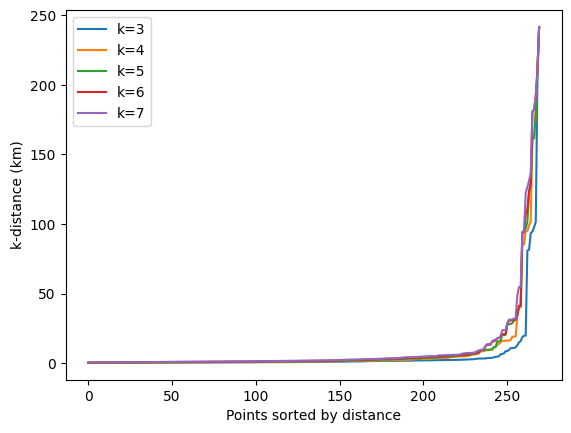

In [ ]:
for k in [3,4,5,6,7]:
    nn = NearestNeighbors(n_neighbors=k, metric='haversine')
    nn.fit(coords_rad)
    dist_rad, _ = nn.kneighbors(coords_rad)
    kdist_km = np.sort(dist_rad[:, -1]) * EARTH_R
    plt.plot(kdist_km, label=f'k={k}')

plt.ylabel("k-distance (km)")
plt.xlabel("Points sorted by distance")
plt.legend()
plt.show()


The k-distance plot for values of k ranging from 3 to 7 shows that most stations have very small nearest-neighbor distances, forming a long flat section in the curve. This indicates that the majority of stations are located in dense clusters with minimal separation. Toward the right-hand side of the plot, there is a sharp increase in k-distance, suggesting that a small number of stations are geographically isolated from the main cluster and could represent outliers or edge cases.

Importantly, the “elbow” in the curve is consistent across different values of k, appearing in the range of approximately 40–60 km. From the figure above, we should consider the k number between 4 to 6, as this range balances cluster density and stability and the curve increase significant first. This elbow point also provides a useful guideline for selecting the eps parameter in DBSCAN, as it captures the dense clusters while excluding distant, sparsely connected stations. Overall, the analysis confirms a strong core group of stations with a few outliers, making density-based clustering a suitable approach for this dataset.

In [ ]:
from numpy import percentile
results = []
for k in [4,5,6]:
    nn = NearestNeighbors(n_neighbors=k, algorithm='ball_tree', metric='haversine')
    nn.fit(coords_rad)
    dist_rad, _ = nn.kneighbors(coords_rad)
    kdist_km = np.sort(dist_rad[:, -1]) * EARTH_R

    for q in [70,75,80,85,90]:
        eps_km = float(percentile(kdist_km, q))
        eps_rad = eps_km / EARTH_R
        db = DBSCAN(eps=eps_rad, min_samples=k, metric='haversine', algorithm='ball_tree')
        labels = db.fit_predict(coords_rad)
        n_clusters = len(set(labels) - {-1})
        noise_pct = (labels == -1).mean() * 100
        results.append((k, q, eps_km, n_clusters, noise_pct))

res_df = pd.DataFrame(results, columns=['k','percentile','eps_km','n_clusters','noise_pct'])
print(res_df.sort_values(['k','percentile']))


    k  percentile     eps_km  n_clusters  noise_pct
0   4          70   2.321035          12  25.185185
1   4          75   2.901352          13  21.111111
2   4          80   3.916660           9  17.407407
3   4          85   5.854658           5  13.333333
4   4          90  11.401549           4   9.259259
5   5          70   3.016420          11  25.925926
6   5          75   3.675250          10  21.851852
7   5          80   4.806767           8  16.296296
8   5          85   6.299661           5  13.333333
9   5          90  11.404056           4   9.259259
10  6          70   3.560404          10  27.037037
11  6          75   4.456120          11  18.148148
12  6          80   5.393466           7  15.555556
13  6          85   6.811065           5  13.333333
14  6          90  15.688060           4   8.888889


The DBSCAN parameter tuning results show how different combinations of nearest neighbours and distance percentiles influence the eps value, number of clusters, and proportion of noise points. In other words, lower percentiles lead to smaller eps values, producing more clusters and increasing the percentage of noise, while higher percentiles increase eps, which reduces the number of clusters and risks merging distinct groups. According to the table above, for k = 6 and percentile = 85, the results give an eps of approximately 6.81 km, which proves that 7 well-defined clusters with only 13.3% noise points. This shows a good balance between preserving the natural cluster structure and limiting the amount of noise, without collapsing clusters into overly broad groups as seen at higher percentiles. Therefore, the choice of k = 6 and percentile = 85 is appropriate for clustering stations and ensuring the stability of the model.

In [ ]:
# DBSCAN clustering of stations based on geographic coordinates
# after finalizing eps_km
db = DBSCAN(
    eps=6.811065 / EARTH_R,
    min_samples=6,
    metric='haversine',
    algorithm='ball_tree',
    n_jobs=-1
)
station_locs['geo_cluster'] = db.fit_predict(coords_rad)

# Statistics
stats = station_locs['geo_cluster'].value_counts().rename_axis('cluster').to_frame('n_stations')
n_clusters = (stats.loc[stats.index != -1]).shape[0]
total = int(stats['n_stations'].sum())
noise = int(stats.loc[-1, 'n_stations']) if -1 in stats.index else 0
print(stats.sort_index())
print(f'Total stations: {total} | Valid clusters: {n_clusters} | Noise: {noise} ({noise/total:.1%})')

# Assign clusters back to the daily dataframe
df = clean_data.merge(station_locs[['station_id', 'geo_cluster']], on='station_id', how='left')


         n_stations
cluster            
-1               36
 0               29
 1               10
 2               10
 3              174
 4               11
Total stations: 270 | Valid clusters: 5 | Noise: 36 (13.3%)


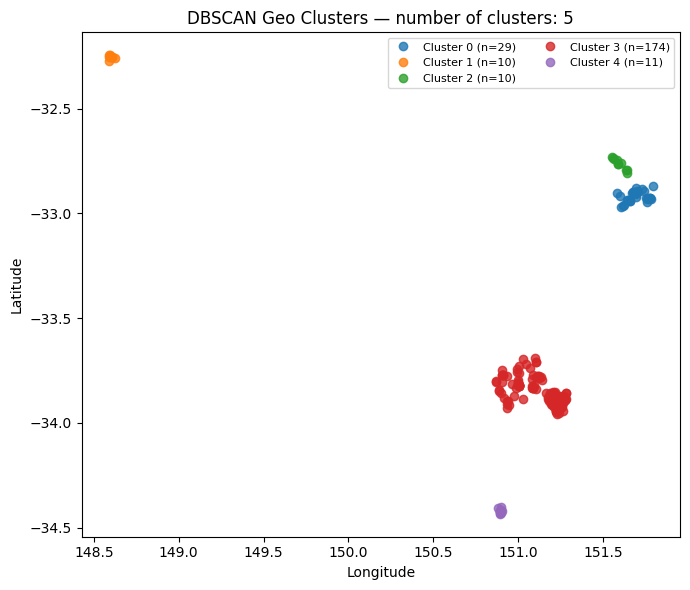

In [ ]:
# Visualization: Plot DBSCAN geographic clusters of stations
labels = station_locs['geo_cluster'].to_numpy()
X = station_locs[['Longitude', 'Latitude']].to_numpy()

show_noise = False

# Number of clusters (excluding noise = -1)
unique_labels = sorted(set(labels))
n_clusters_ = len([k for k in unique_labels if k != -1])

plt.figure(figsize=(7,6))

for k in unique_labels:
    if k == -1:
        if not show_noise:
            continue
        mask = (labels == -1)
        xy = X[mask]
        if len(xy) > 0:
            plt.plot(
                xy[:,0], xy[:,1], 'x', ms=6, alpha=0.6,
                label=f'Noise (n={len(xy)})'
            )
    else:
        mask = (labels == k)
        xy = X[mask]
        if len(xy) > 0:
            # Each cluster is drawn with dots (no distinction between core/border points)
            plt.plot(
                xy[:,0], xy[:,1], 'o', ms=6, alpha=0.8,
                label=f'Cluster {k} (n={len(xy)})'
            )

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'DBSCAN Geo Clusters — number of clusters: {n_clusters_}')
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


The DBSCAN geo clustering results reveal seven distinct clusters of stations, each varying in size and geographic concentration. The largest cluster, shown in purple, contains 191 stations and is densely concentrated around the Sydney metropolitan area, reflecting the city’s role as the primary demand hub. Medium-sized clusters, such as the blue and green groups, consist of about 10–29 stations each and represent smaller but still locally dense regions. In contrast, the orange and purple clusters are much smaller, with only 10–11 stations, indicating isolated or regional coverage areas outside the urban core. The clusters are well separated spatially, showing minimal overlap, which highlights the algorithm’s ability to distinguish between urban and regional demand zones. From a practical standpoint, this distribution suggests that while the majority of demand will be concentrated in the largest urban cluster, the smaller clusters represent secondary zones that may either be underserved or in need of targeted infrastructure planning. If outliers were displayed, they would likely correspond to isolated stations in remote areas, requiring unique treatment in demand forecasting. Overall, the clustering provides clear insights into station density and regional distribution, supporting strategic decisions for both capacity management and network expansion.


The spatial separation between clusters is clear, with minimal overlap, demonstrating DBSCAN’s effectiveness in distinguishing urban demand zones from regional or remote areas. Strategically, this distribution suggests that while the bulk of demand will be concentrated in the Sydney cluster, the smaller peripheral clusters highlight secondary demand areas. These may require tailored infrastructure planning—either to expand coverage in underserved regions or to manage growth in emerging hotspots.

In [ ]:
# Check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542160 entries, 0 to 542159
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  542160 non-null  object 
 1   station_id            542160 non-null  int64  
 2   Station name          542160 non-null  object 
 3   Number of station     542160 non-null  float64
 4   Number of plugs       542160 non-null  float64
 5   Latitude              542160 non-null  float64
 6   Longitude             542160 non-null  float64
 7   day_of_week           542160 non-null  float64
 8   public_holiday        542160 non-null  float64
 9   school_holiday        542160 non-null  float64
 10  Avg_Temp              542160 non-null  float64
 11  Avg_Humidity          542160 non-null  float64
 12  Avg_Wind              542160 non-null  float64
 13  is_weekend            542160 non-null  float64
 14  daily_total           542160 non-null  float64
 15  

In [ ]:
# Create the external factor list
cand_exog = ['public_holiday','school_holiday','Avg_Temp','Avg_Humidity','Avg_Wind','is_weekend']
exog_cols  = [c for c in cand_exog if c in df.columns]


In [ ]:
# Convert the date column into the right data type
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [ ]:
# Check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542160 entries, 0 to 542159
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Date                  542160 non-null  datetime64[ns]
 1   station_id            542160 non-null  int64         
 2   Station name          542160 non-null  object        
 3   Number of station     542160 non-null  float64       
 4   Number of plugs       542160 non-null  float64       
 5   Latitude              542160 non-null  float64       
 6   Longitude             542160 non-null  float64       
 7   day_of_week           542160 non-null  float64       
 8   public_holiday        542160 non-null  float64       
 9   school_holiday        542160 non-null  float64       
 10  Avg_Temp              542160 non-null  float64       
 11  Avg_Humidity          542160 non-null  float64       
 12  Avg_Wind              542160 non-null  float64       
 13 

In [ ]:
# Group the data by geo_cluster and date
df_group = df.groupby(['geo_cluster','Date'], as_index=True)
df_group.head(5)

Date  station_id             Station name  Number of station  \
0      2020-01-01          61          Mackellar Motel                2.0   
1      2020-01-02          61          Mackellar Motel                2.0   
2      2020-01-03          61          Mackellar Motel                2.0   
3      2020-01-04          61          Mackellar Motel                2.0   
4      2020-01-05          61          Mackellar Motel                2.0   
...           ...         ...                      ...                ...   
524083 2025-06-26         823  1 Georges Place Parking                1.0   
524084 2025-06-27         823  1 Georges Place Parking                1.0   
524085 2025-06-28         823  1 Georges Place Parking                1.0   
524086 2025-06-29         823  1 Georges Place Parking                1.0   
524087 2025-06-30         823  1 Georges Place Parking                1.0   

        Number of plugs   Latitude   Longitude  day_of_week  public_holiday  \
0                   2.0 -30.980048  150.257659          3.0             0.0   
1                   2.0 -30.980048  150.257659          4.0             0.0   
2                   2.0 -30.980048  150.257659          5.0             0.0   
3                   2.0 -30.980048  150.257659          6.0             0.0   
4                   2.0 -30.980048  150.257659          7.0             0.0   
...                 ...        ...         ...          ...             ...   
524083              2.0 -34.418637  150.902172          4.0             0.0   
524084              2.0 -34.418637  150.902172          5.0             0.0   
524085              2.0 -34.418637  150.902172          6.0             0.0   
524086              2.0 -34.418637  150.902172          7.0             0.0   
524087              2.0 -34.418637  150.902172          1.0             0.0   

        school_holiday  Avg_Temp  Avg_Humidity  Avg_Wind  is_weekend  \
0                  1.0     22.43         70.00     20.96         0.0   
1                  1.0     22.43         70.00     20.96         0.0   
2                  1.0     24.80         73.50     18.02         0.0   
3                  1.0     30.10         54.04     27.47         1.0   
4                  1.0     22.28         66.84     34.90         1.0   
...                ...       ...           ...       ...         ...   
524083             0.0     11.02         53.69     26.18         0.0   
524084             0.0     11.98         67.96     19.42         0.0   
524085             0.0     12.90         74.27     10.93         1.0   
524086             0.0     12.81         75.27     11.29         1.0   
524087             0.0     13.08         77.08     17.31         0.0   

        daily_total  estimated_demand_kWh  geo_cluster  
0            1507.0              26464.81           -1  
1            1507.0              26464.81           -1  
2            1583.0              27640.15           -1  
3            2559.0              44002.65           -1  
4            2268.0              39050.06           -1  
...             ...                   ...          ...  
524083       6737.0             113848.07            4  
524084       6563.0             110921.29            4  
524085       4975.0              83743.11            4  
524086       4015.0              67399.05            4  
524087       6023.0             101883.19            4  

[60240 rows x 17 columns]

In [ ]:
# Create a function to create a daily time series frame aggregated by geo_cluster and Date
def make_daily_frame(df_group, y_col, exog_cols, freq='D'):
    # Create aggregation dictionary
    agg = {y_col: 'sum'}
    for c in exog_cols:
        if c in ['public_holiday', 'school_holiday', 'is_weekend']:
            agg[c] = 'max'
        else:
            agg[c] = 'mean'

    # Group by geo_cluster and Date
    g_daily = (df_group.groupby(['geo_cluster', 'Date'], as_index=True)
                        .agg(agg)
                        .sort_index())

    out_list = []
    for cid, g in g_daily.groupby(level=0):   # for each geo_cluster
        # Set Date as DatetimeIndex
        g = g.droplevel(0).sort_index()       # index = Date
        g = g.sort_index()

        # Create full date range to reindex
        full_idx = pd.date_range(g.index.min(), g.index.max(), freq=freq)

        # Target variable y
        y = g[[y_col]].reindex(full_idx).asfreq(freq).fillna(0.0)

        # Exogenous variables X
        if exog_cols:
            # only keep exog columns that still exist after aggregation
            exog_present = [c for c in exog_cols if c in g.columns]
            X = g[exog_present].reindex(full_idx).asfreq(freq)
            # fill missing exog values with forward/backward fill
            X = X.ffill().bfill()
            out = pd.concat([y, X], axis=1)
        else:
            out = y

        out.index.name = 'Date'
        out['geo_cluster'] = cid
        out_list.append(out)

    # Combine results: includes Date + geo_cluster
    result = pd.concat(out_list).reset_index()
    return result


In [ ]:
geo_data = make_daily_frame(df, 'estimated_demand_kWh', exog_cols)
geo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12048 entries, 0 to 12047
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  12048 non-null  datetime64[ns]
 1   estimated_demand_kWh  12048 non-null  float64       
 2   public_holiday        12048 non-null  float64       
 3   school_holiday        12048 non-null  float64       
 4   Avg_Temp              12048 non-null  float64       
 5   Avg_Humidity          12048 non-null  float64       
 6   Avg_Wind              12048 non-null  float64       
 7   is_weekend            12048 non-null  float64       
 8   geo_cluster           12048 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 847.3 KB


In [ ]:
geo_data.head(5)

Date  estimated_demand_kWh  public_holiday  school_holiday   Avg_Temp  \
0 2020-01-01            6961596.71             0.0             1.0  22.212222   
1 2020-01-02            6097220.65             0.0             1.0  22.678611   
2 2020-01-03            6768273.57             0.0             1.0  24.792778   
3 2020-01-04            6564854.03             0.0             1.0  29.069444   
4 2020-01-05            7175393.52             0.0             1.0  22.412778   

   Avg_Humidity   Avg_Wind  is_weekend  geo_cluster  
0     70.291667  22.471667         0.0           -1  
1     69.972222  20.998333         0.0           -1  
2     72.819444  18.131667         0.0           -1  
3     56.232778  26.944444         1.0           -1  
4     66.529444  34.073889         1.0           -1

In [ ]:
geo_data = geo_data.set_index("Date").sort_index()
geo_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12048 entries, 2020-01-01 to 2025-06-30
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   estimated_demand_kWh  12048 non-null  float64
 1   public_holiday        12048 non-null  float64
 2   school_holiday        12048 non-null  float64
 3   Avg_Temp              12048 non-null  float64
 4   Avg_Humidity          12048 non-null  float64
 5   Avg_Wind              12048 non-null  float64
 6   is_weekend            12048 non-null  float64
 7   geo_cluster           12048 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 847.1 KB


- Check outliers of the datasets using IQR

Cluster 0 | Lower bound: 1776050.38, Upper bound: 12154360.78
Outliers detected: 100


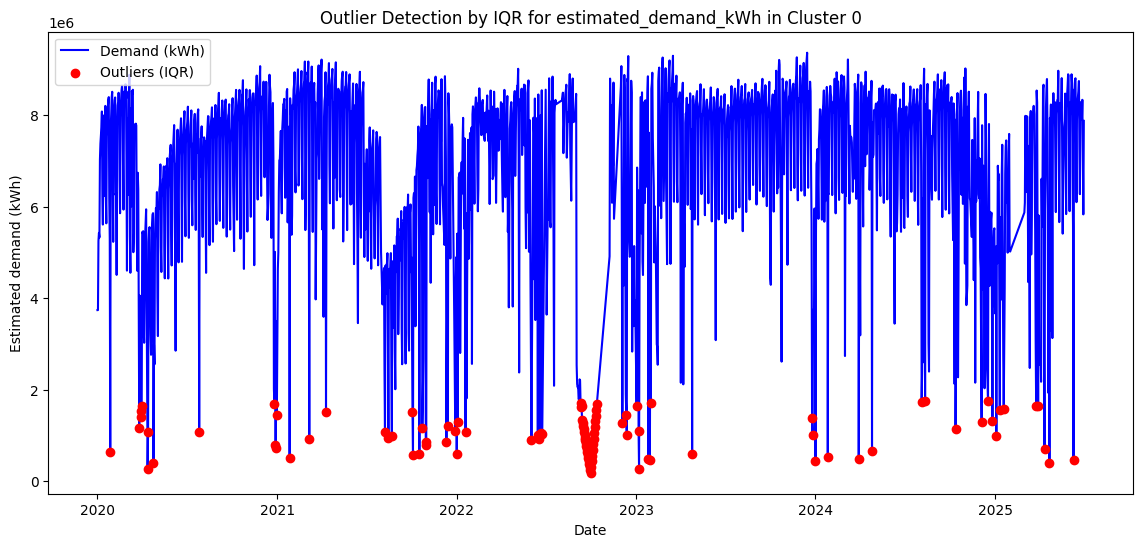

Cluster 1 | Lower bound: 110764.32, Upper bound: 818985.93
Outliers detected: 44


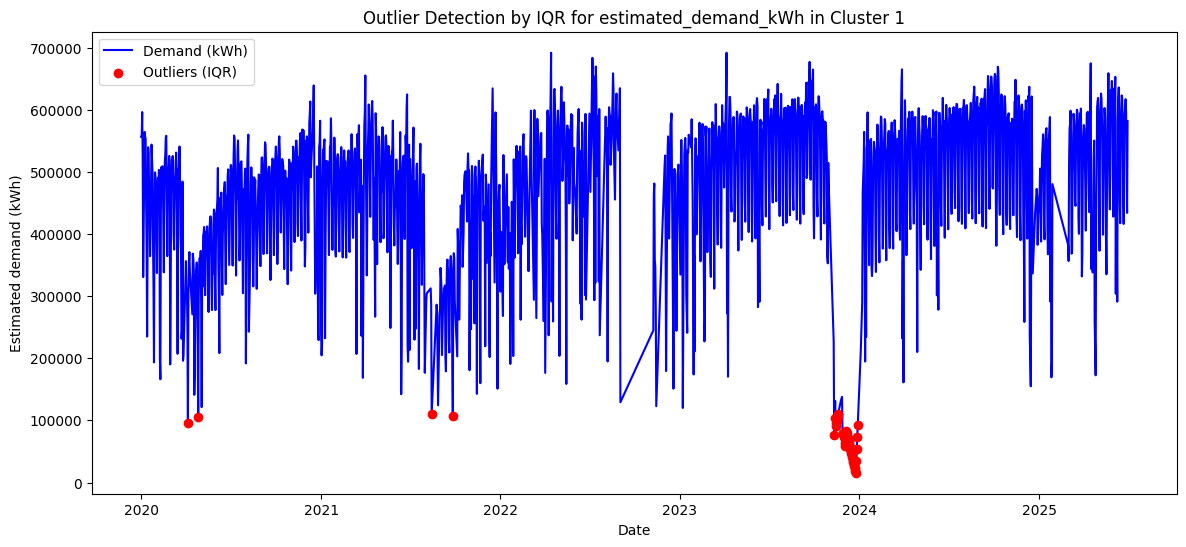

Cluster 2 | Lower bound: -239832.75, Upper bound: 8149160.16
Outliers detected: 0


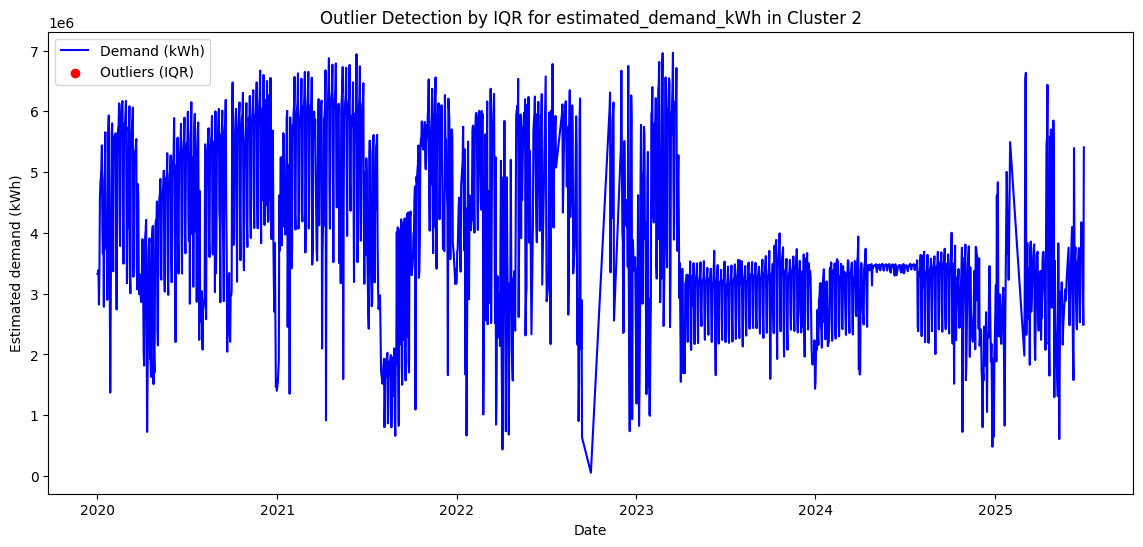

Cluster 3 | Lower bound: 31596636.86, Upper bound: 152340805.84
Outliers detected: 7


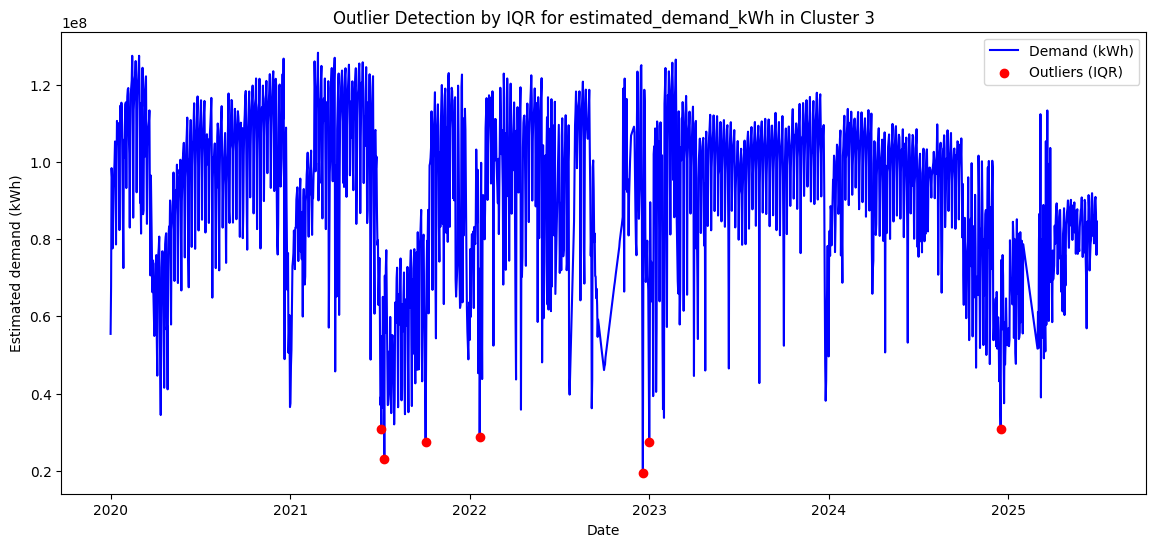

Cluster 4 | Lower bound: 155860.67, Upper bound: 1791797.93
Outliers detected: 48


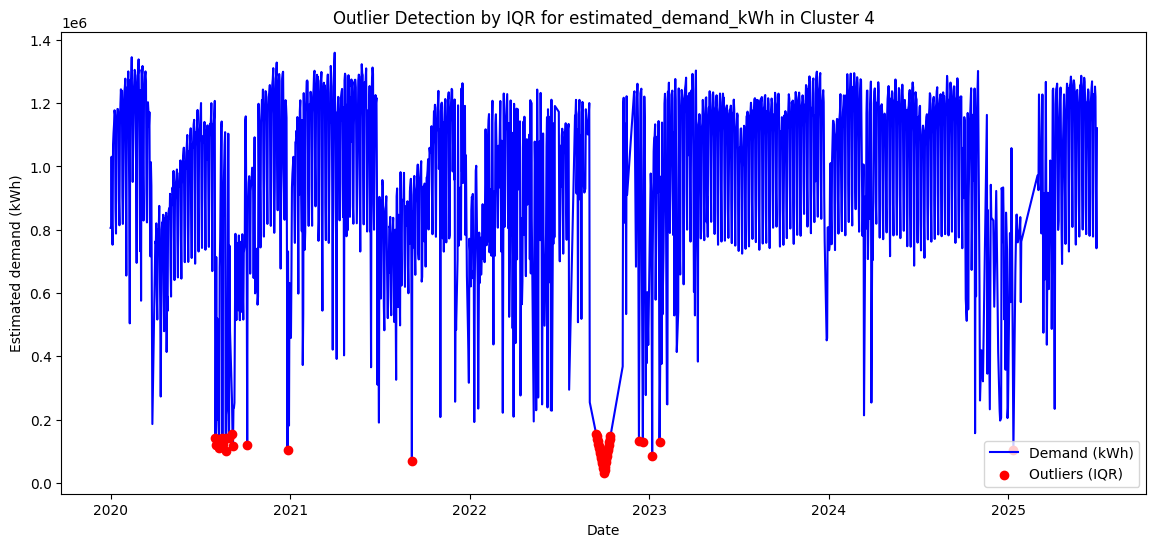

In [ ]:
# Keep the same cluster range
geo_number = range(0, 5)

# Initialize outlier flag
geo_data['is_outlier'] = False

for i in geo_number:
    # Create mask index for cluster i
    idx = (geo_data['geo_cluster'] == i)

    # Get view by mask and copy for safe calculation (avoid chained assignment)
    df = geo_data.loc[idx].copy()

    # Detect outliers by IQR
    Q1 = df['estimated_demand_kWh'].quantile(0.25)
    Q3 = df['estimated_demand_kWh'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Compute outlier mask on df (copy)
    mask_out = (df['estimated_demand_kWh'] < lower_bound) | (df['estimated_demand_kWh'] > upper_bound)

    # CWrite results directly back into geo_data using .loc
    geo_data.loc[idx, 'is_outlier'] = mask_out.values

    # Extract outliers from geo_data for printing & plotting
    outliers = geo_data.loc[idx & geo_data['is_outlier']]

    print(f"Cluster {i} | Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
    print(f"Outliers detected: {len(outliers)}")

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['estimated_demand_kWh'], label="Demand (kWh)", color="blue")
    plt.scatter(outliers.index, outliers['estimated_demand_kWh'], color="red", label="Outliers (IQR)", zorder=5)
    plt.title(f"Outlier Detection by IQR for estimated_demand_kWh in Cluster {i}")
    plt.xlabel("Date")
    plt.ylabel("Estimated demand (kWh)")
    plt.legend()
    plt.show()


- Create a function ot remove outliers

In [ ]:
def fix_outliers(g):
    # Build masks
    mask_event = (g['school_holiday'] == 1) | (g['public_holiday'] == 1) | (g['is_weekend'] == 1)
    mask_sensor_error = g['is_outlier'].astype(bool) & (~mask_event)

    # Work on a float copy of the target series
    s = g['estimated_demand_kWh'].astype(float)

    # Blank out the outliers so interpolation has something to fill
    s.loc[mask_sensor_error] = np.nan

    # Interpolate by time; fill edges as well
    s = s.interpolate(method='time', limit_direction='both')

    # Write back
    g['estimated_demand_kWh'] = s

    # Return original shape
    return g.reset_index()

# apply per-geo group; drop the flag after fixing
geo_clean = (
    geo_data
    .groupby("geo_cluster", group_keys=False)
    .apply(fix_outliers)
    .drop(columns=['is_outlier'])
)


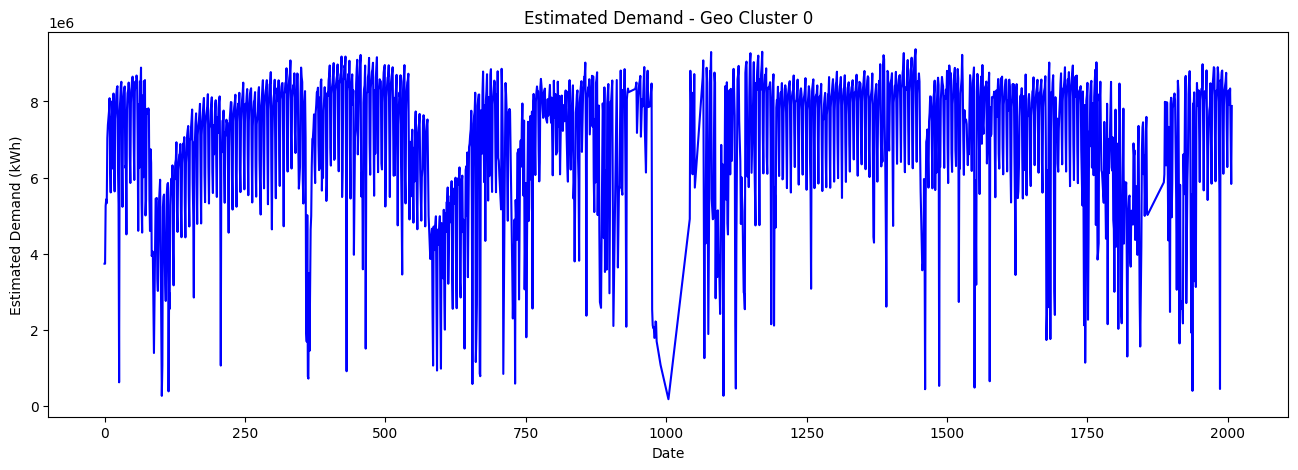

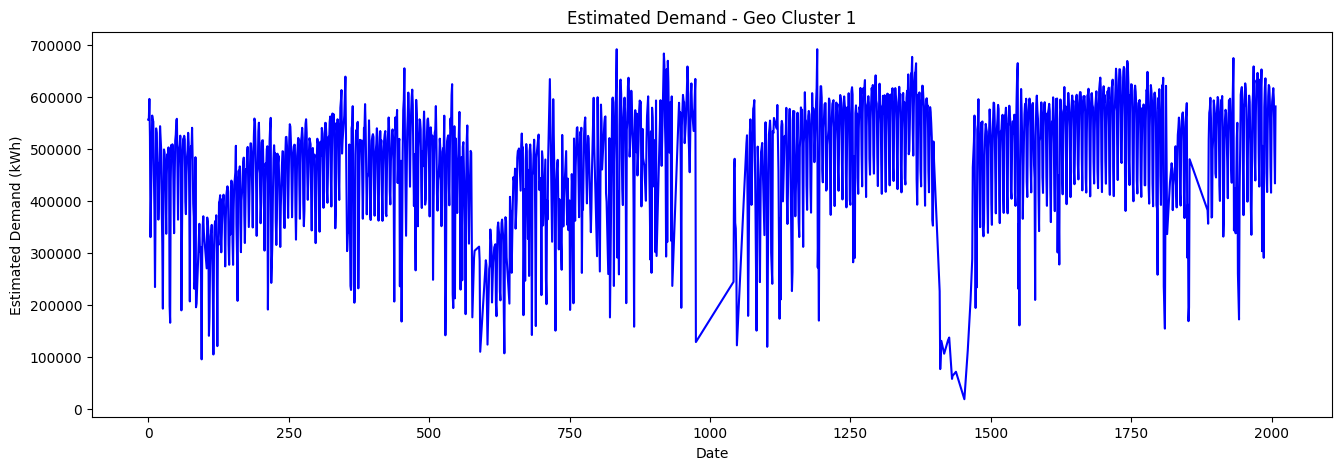

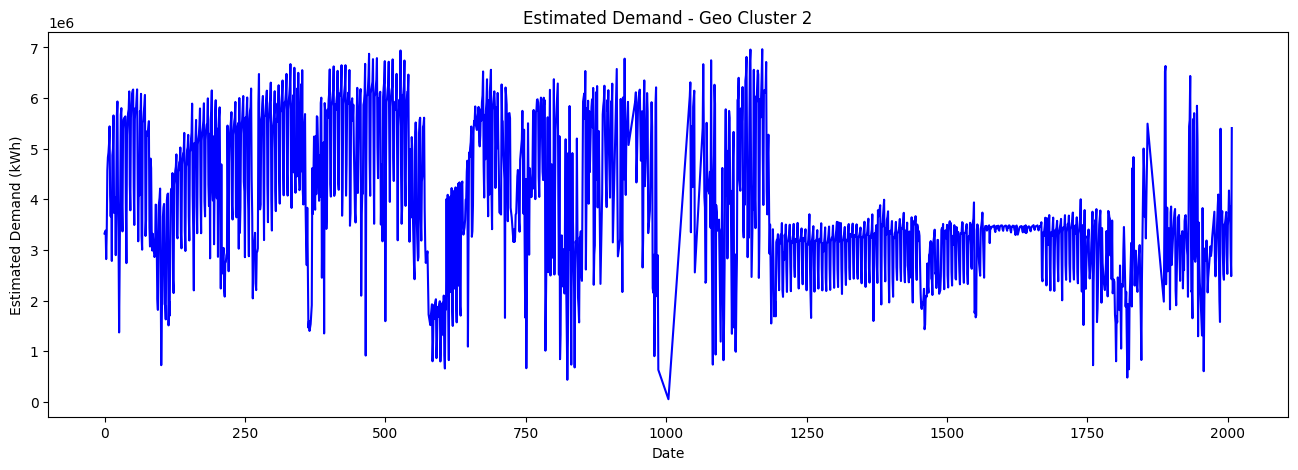

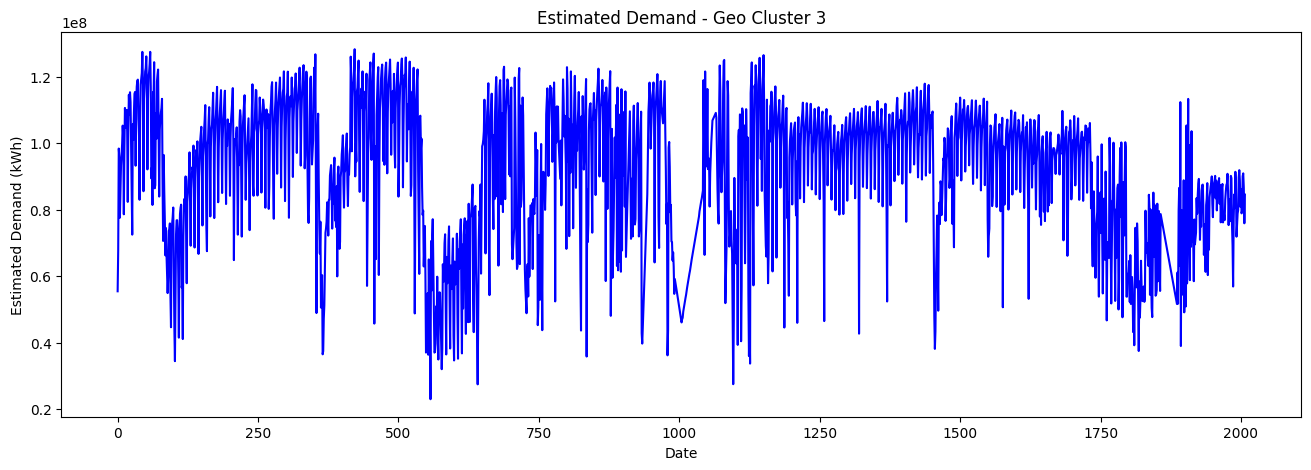

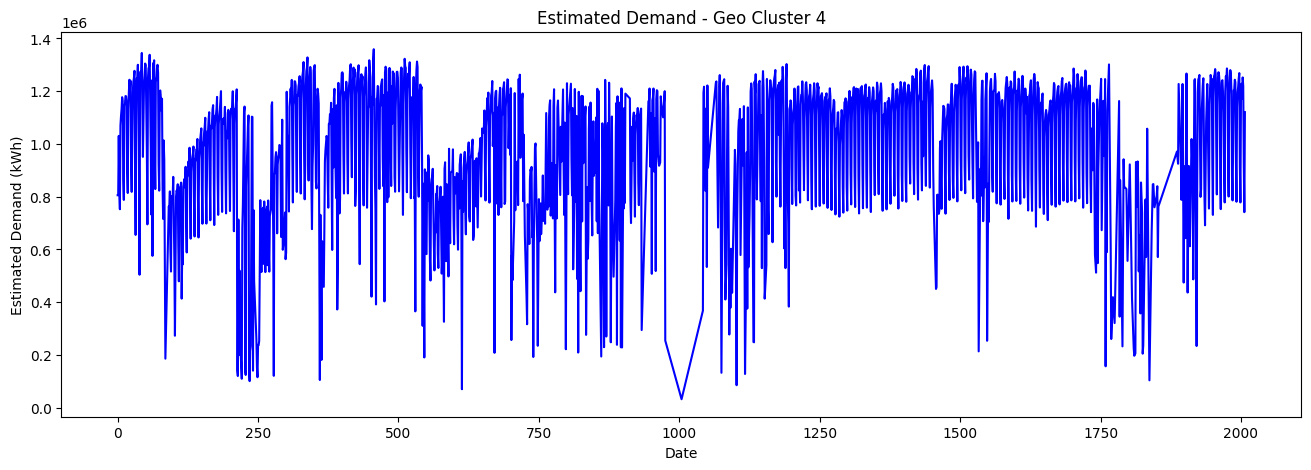

In [ ]:
# Plot the data again after cleaning data

for i in geo_number:
  plt.figure(figsize=(16,5))
  plt.plot(geo_clean[geo_clean['geo_cluster'] == i].index,
           geo_clean[geo_clean['geo_cluster'] == i]['estimated_demand_kWh'], color="blue")
  plt.title(f"Estimated Demand - Geo Cluster {i}")
  plt.xlabel("Date")
  plt.ylabel("Estimated Demand (kWh)")
  plt.show()

In [ ]:
# Check data type
geo_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12048 entries, 0 to 2007
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  12048 non-null  datetime64[ns]
 1   estimated_demand_kWh  12048 non-null  float64       
 2   public_holiday        12048 non-null  float64       
 3   school_holiday        12048 non-null  float64       
 4   Avg_Temp              12048 non-null  float64       
 5   Avg_Humidity          12048 non-null  float64       
 6   Avg_Wind              12048 non-null  float64       
 7   is_weekend            12048 non-null  float64       
 8   geo_cluster           12048 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 941.2 KB


- Check stationary of datapoint

In [ ]:
def perform_adf_test(data):
    # Perform ADF test
    result = adfuller(data)

    # Print the results
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    # Check if the data is stationary based on the p-value
    if result[1] <= 0.05:
        print("The data is stationary")
    else:
        print("The data is not stationary, Data can be processed further")



In [ ]:
for i in geo_number:
  print(f"Geo Cluster {i}")
  perform_adf_test(geo_clean[geo_clean['geo_cluster'] == i]['estimated_demand_kWh'])
  print("------------------")

Geo Cluster 0
ADF Statistic: -4.751739621684897
p-value: 6.720621977644472e-05
Critical Values: {'1%': -3.4336502927748587, '5%': -2.8629978852039737, '10%': -2.5675461168480913}
The data is stationary
------------------
Geo Cluster 1
ADF Statistic: -4.393748621889854
p-value: 0.0003044862002833064
Critical Values: {'1%': -3.433648628001351, '5%': -2.8629971502062155, '10%': -2.5675457254979093}
The data is stationary
------------------
Geo Cluster 2
ADF Statistic: -4.286839986817791
p-value: 0.0004681082409740744
Critical Values: {'1%': -3.433645303487856, '5%': -2.8629956824317757, '10%': -2.5675449439803617}
The data is stationary
------------------
Geo Cluster 3
ADF Statistic: -4.434165299265499
p-value: 0.0002581242963551999
Critical Values: {'1%': -3.433648628001351, '5%': -2.8629971502062155, '10%': -2.5675457254979093}
The data is stationary
------------------
Geo Cluster 4
ADF Statistic: -4.4609269927372095
p-value: 0.00023120209177746422
Critical Values: {'1%': -3.43364696490

**2. Build GRU Model for EV Charging Demand Prediction**

- Create the function to split the training and testing dataset

In [ ]:
start = 2020
end = 2023

def time_split(df, start_year, end_year):
    train_df = df.loc[f"{start_year}":f"{end_year}"]
    test_df  = df.loc[f"{end_year+1}":]
    return train_df, test_df

- Create the function to split x_train, y_train, x_test, y_test

In [ ]:
def split_sequence(sequence, n_steps, forecasting_horizon, y_index):
    X, y = list(), list()
    for i in range(len(sequence)):
      end_ix = i + n_steps
      if end_ix > len(sequence)-forecasting_horizon:
        break
      seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+forecasting_horizon, y_index]
      X.append(seq_x)
      y.append(seq_y)
    return np.array(X), np.array(y)

- Create the function to calculate the evaluation's metric

In [ ]:
def return_metrics(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  rmse = root_mean_squared_error(y_true, y_pred)
  print("MAE: {:.2f}".format(mae))
  print("MAPE: {:.2%}".format(mape))
  print("RMSE: {:2f}".format(rmse))
  return mae, mape, rmse

- Implement the GRU model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

In [ ]:
GRU_result ={}

for i in geo_number:
  df = geo_clean[geo_clean['geo_cluster'] == i]
  df = df.drop(columns=['geo_cluster'])
  df.set_index('Date', inplace= True)


  #Split the trainning and testing dataset
  training_set, test_set = time_split(df, start, end)

  #Save the train
  training_set_shape = training_set.shape
  test_set_shape = test_set.shape

  #Import the min_max scaller
  sc = MinMaxScaler(feature_range =(0,1))

  #Reshape training_set
  training_set = training_set.values.reshape(-1,1)
  training_set_scaled = sc.fit_transform(training_set)
  training_set_scaled = training_set_scaled.reshape(training_set_shape[0], test_set_shape[1])

  #Parameter prepare for the model
  n_steps = 50
  forecasting_horizon = 14
  features = 7
  y_index = 0

  #Split the X_train and y_train for model
  X_train, y_train = split_sequence(training_set_scaled, n_steps, forecasting_horizon, y_index)

  #Reshaping Y_train for model
  y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

  #Set the gru_model
  model_gru = Sequential()
  model_gru.add(GRU(units=128,activation="tanh", return_sequences=False, input_shape=(n_steps, features)))
  model_gru.add(Dropout(0.2))
  model_gru.add(Dense(units=14))
  model_gru.compile(optimizer=Adamax(learning_rate=0.001), loss='mean_squared_error')

  #Set the early stop
  early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0, restore_best_weights=True)
  model_gru.fit(X_train, y_train, epochs=200, batch_size=64, verbose=0, callbacks=[early_stop])

  #Set the RNN testing
  input_values = test_set.values.reshape(-1,1)
  input_values = sc.transform(input_values)
  input_values = input_values.reshape(test_set_shape[0], test_set_shape[1])

  #Split the X_test and y_test
  X_test, y_test = split_sequence(input_values, n_steps, forecasting_horizon, y_index)

  #Predict the values
  predict_EV_demand = model_gru.predict(X_test)
  predict_EV_demand = sc.inverse_transform(predict_EV_demand)

  #Inverst the testing values
  y_test = y_test.reshape(y_test.shape[0],y_test.shape[1])
  y_test = sc.inverse_transform(y_test)


  GRU_result[i] = {
      "model" : model_gru,
      "predict_EV_demand": predict_EV_demand,
      "y_test" : y_test,
  }



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
best_GRU_result = {}

for geo_id, res in GRU_result.items():
    y_true = res["y_test"]
    y_pred = res["predict_EV_demand"]
    horizon = min(y_true.shape[1], y_pred.shape[1])

    # Initialize the best result for this geo_id
    best_for_geo = {
        "horizon": None,
        "mape": float("inf"),
        "mae": None,
        "rmse": None,
        "model": None,
        "y_test": None,
        "y_pred": None,
        "dates": None
    }

    print(f"\nGeo_id: {geo_id}")
    for i in range(horizon):
        mae, mape, rmse = return_metrics(y_true[:, i], y_pred[:, i])
        print(f"Horizon {i} | MAE={mae:.2f}, MAPE={mape:.2%}, RMSE={rmse:.2f}")

        # Update if MAPE is smaller than the current best for this geo_id
        if mape < best_for_geo["mape"]:
            best_for_geo = {
                "horizon": i,
                "mape": mape,
                "mae": mae,
                "rmse": rmse,
                "model": res["model"],
                "y_test": y_true[:, i],
                "y_pred": y_pred[:, i],
                "dates": res["y_test"]
            }

    # Save the best result for this geo_id
    best_GRU_result[geo_id] = best_for_geo
    print("------------------")



Geo_id: 0
MAE: 1112763.89
MAPE: 33.64%
RMSE: 1575043.761721
Horizon 0 | MAE=1112763.89, MAPE=33.64%, RMSE=1575043.76
MAE: 1199790.93
MAPE: 35.89%
RMSE: 1657301.460485
Horizon 1 | MAE=1199790.93, MAPE=35.89%, RMSE=1657301.46
MAE: 1210719.48
MAPE: 36.28%
RMSE: 1685682.585011
Horizon 2 | MAE=1210719.48, MAPE=36.28%, RMSE=1685682.59
MAE: 1186111.12
MAPE: 36.52%
RMSE: 1680201.372682
Horizon 3 | MAE=1186111.12, MAPE=36.52%, RMSE=1680201.37
MAE: 1199646.17
MAPE: 36.36%
RMSE: 1681683.317834
Horizon 4 | MAE=1199646.17, MAPE=36.36%, RMSE=1681683.32
MAE: 1197199.03
MAPE: 36.11%
RMSE: 1666374.555630
Horizon 5 | MAE=1197199.03, MAPE=36.11%, RMSE=1666374.56
MAE: 1152670.06
MAPE: 35.79%
RMSE: 1669124.654981
Horizon 6 | MAE=1152670.06, MAPE=35.79%, RMSE=1669124.65
MAE: 1252061.87
MAPE: 36.07%
RMSE: 1703142.529269
Horizon 7 | MAE=1252061.87, MAPE=36.07%, RMSE=1703142.53
MAE: 1283529.76
MAPE: 36.59%
RMSE: 1727150.370833
Horizon 8 | MAE=1283529.76, MAPE=36.59%, RMSE=1727150.37
MAE: 1258676.67
MAPE: 36.6

In [ ]:
print('GRU Model')
print('------------------')
for geo_id, res in best_GRU_result.items():
    y_true = res['y_test']
    mean_val = y_true.mean()

    print(f"Geo_id: {geo_id}")
    print(f"Horizon: {res['horizon']}")
    print(f"MAPE: {res['mape']:.2%}")
    print(f"MAE:  {res['mae']:.2f}")
    print(f"RMSE: {res['rmse']:.2f}")
    print(f"Mean actual demand: {mean_val:.2f}")
    print(f"MAE / Mean = {res['mae']/mean_val:.2%}")
    print(f"RMSE / Mean = {res['rmse']/mean_val:.2%}")
    print("------------------")


GRU Model
------------------
Geo_id: 0
Horizon: 0
MAPE: 33.64%
MAE:  1112763.89
RMSE: 1575043.76
Mean actual demand: 6743081.73
MAE / Mean = 16.50%
RMSE / Mean = 23.36%
------------------
Geo_id: 1
Horizon: 0
MAPE: 10.95%
MAE:  46645.62
RMSE: 64670.87
Mean actual demand: 510747.71
MAE / Mean = 9.13%
RMSE / Mean = 12.66%
------------------
Geo_id: 2
Horizon: 0
MAPE: 19.64%
MAE:  463916.53
RMSE: 694468.74
Mean actual demand: 3145652.98
MAE / Mean = 14.75%
RMSE / Mean = 22.08%
------------------
Geo_id: 3
Horizon: 0
MAPE: 10.68%
MAE:  7827327.33
RMSE: 10747100.16
Mean actual demand: 84077940.61
MAE / Mean = 9.31%
RMSE / Mean = 12.78%
------------------
Geo_id: 4
Horizon: 0
MAPE: 20.22%
MAE:  119043.16
RMSE: 172953.10
Mean actual demand: 955759.17
MAE / Mean = 12.46%
RMSE / Mean = 18.10%
------------------


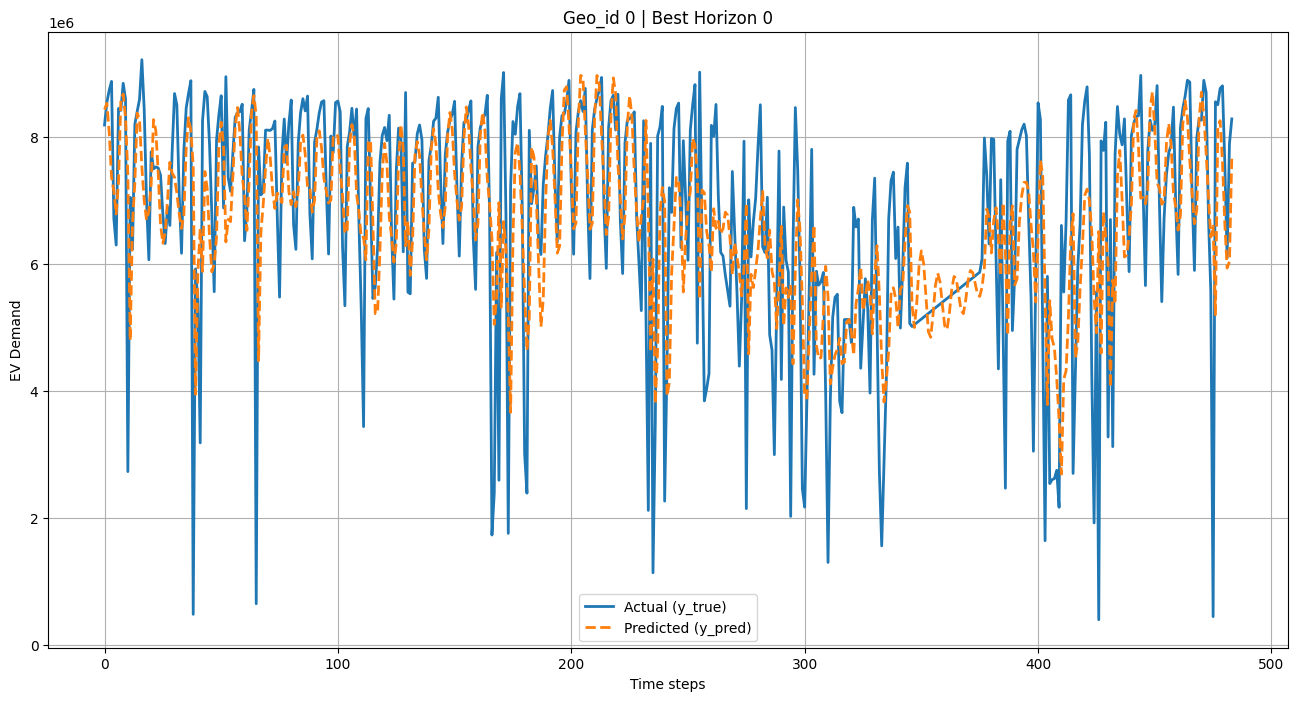

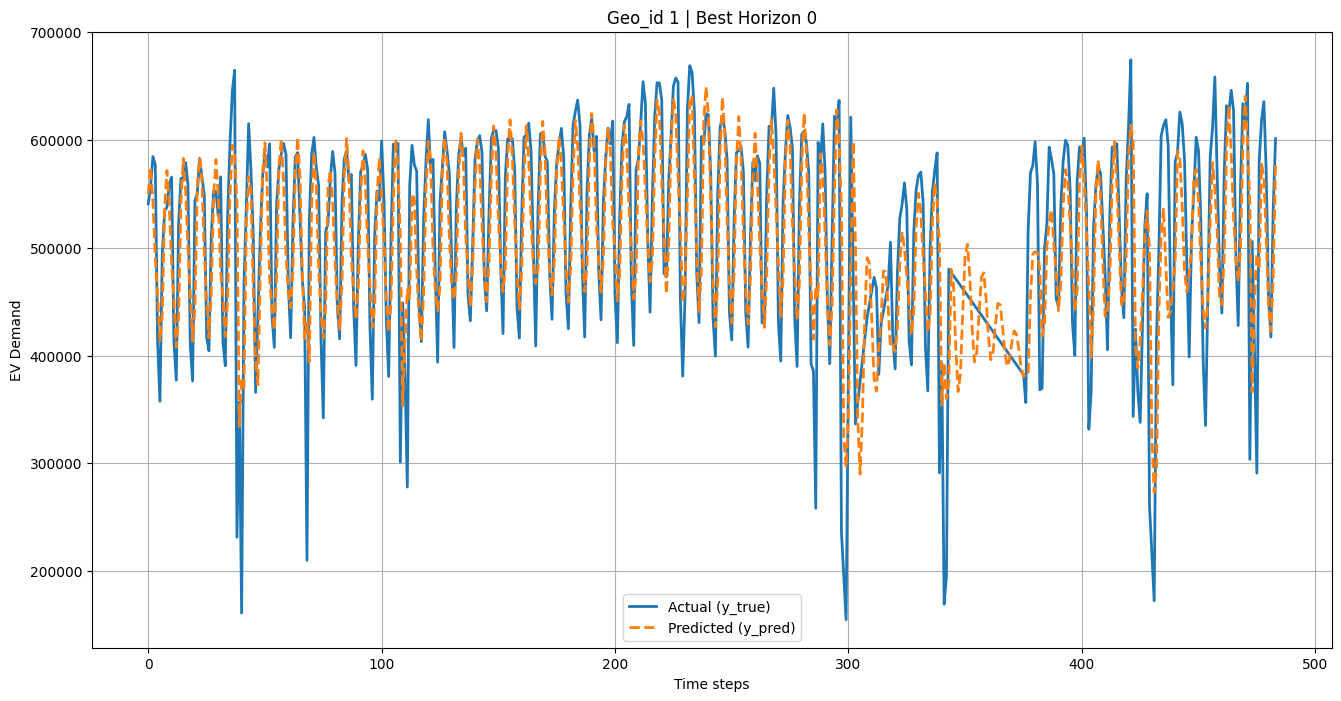

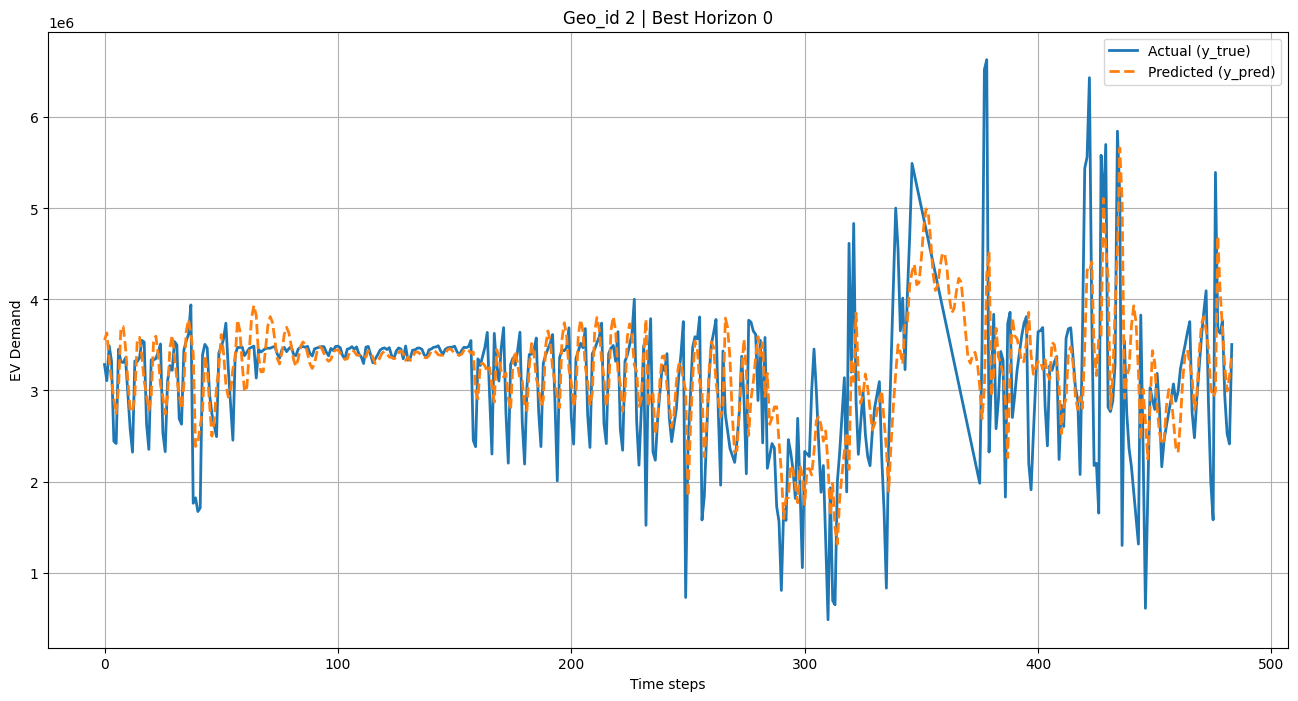

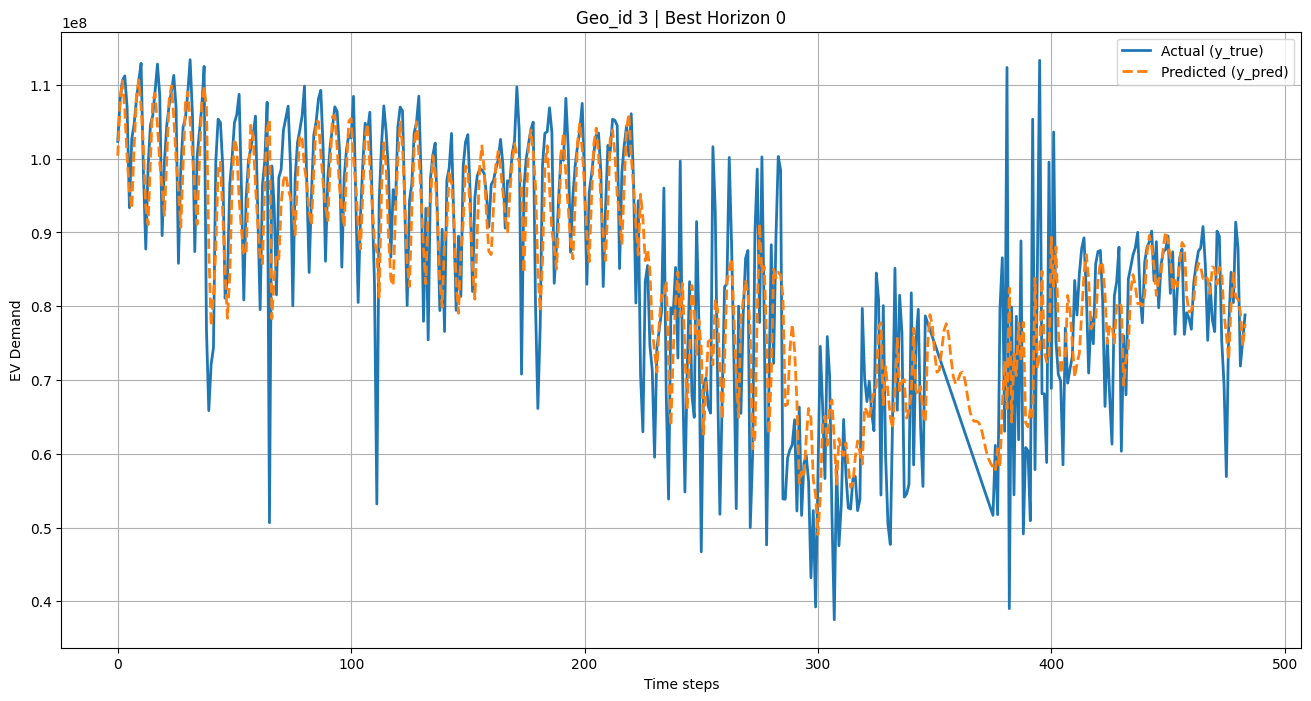

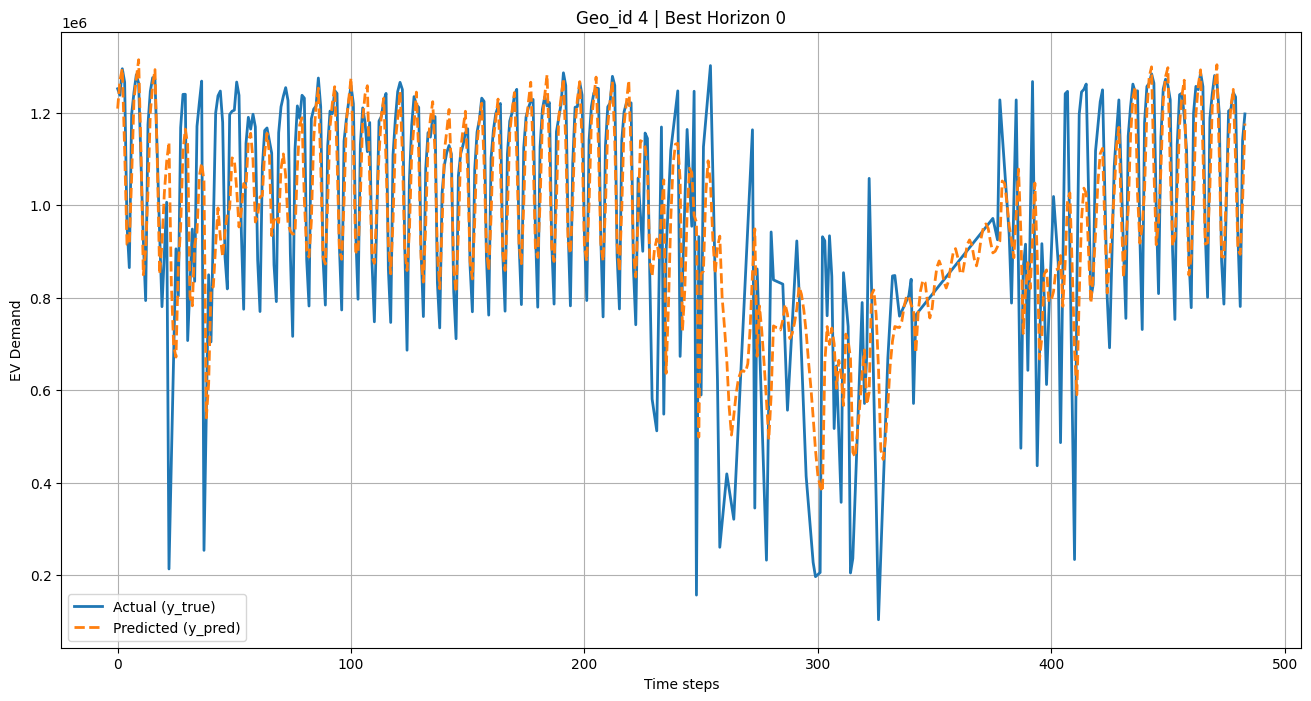

In [ ]:
for geo_id, res in best_GRU_result.items():
    plt.figure(figsize=(16, 8))
    plt.plot(res["y_test"], label="Actual (y_true)", linewidth=2)
    plt.plot(res["y_pred"], label="Predicted (y_pred)", linewidth=2, linestyle="--")
    plt.title(f"Geo_id {geo_id} | Best Horizon {res['horizon']}")
    plt.xlabel("Time steps")
    plt.ylabel("EV Demand")
    plt.legend()
    plt.grid(True)
    plt.show()

**3. Building SARIMA Model for prediction**

In [ ]:
# Function: Hybrid outlier fixing (DOW median + rolling median) with holiday guard
import numpy as np

def fix_outliers_hybrid(g, y='estimated_demand_kWh', win='7D', min_count_dow=5, drop_flag=True):
    g = g.copy()
    base = g[y]

    # Not modify event days (holidays)
    mask_event = (g.get('school_holiday', 0) == 1) | (g.get('public_holiday', 0) == 1)
    mask_out   = g.get('is_outlier', False).astype(bool) & (~mask_event)

    clean_col = f'{y}_clean'
    g[clean_col] = base

    if mask_out.any():
        # “Clean” reference for DOW median: exclude outliers and event days
        ref_mask = (~g.get('is_outlier', False).astype(bool)) & (~mask_event)

        dow = g.index.dayofweek  # 0=Mon ... 6=Sun
        # Median by each DOW
        ref_median_by_dow = g.loc[ref_mask, y].groupby(dow[ref_mask]).median()

        # Sample count by DOW to check reliability threshold
        ref_count_by_dow  = g.loc[ref_mask, y].groupby(dow[ref_mask]).size()

        # Map median & count back to each timestamp
        candidate_dow = dow.map(ref_median_by_dow)
        count_dow     = dow.map(ref_count_by_dow).fillna(0)
        ok_dow        = count_dow.values >= min_count_dow

        # Fallback: time-based rolling median
        med_roll = base.rolling(win, center=True, min_periods=1).median()

        # Replacement vector for outlier positions
        repl = np.where(ok_dow, candidate_dow.to_numpy(), med_roll.to_numpy())

        # 5) Assign back ONLY at outlier positions (don’t change event days)
        idx = mask_out.values
        g.loc[idx, clean_col] = repl[idx]

    if drop_flag and 'is_outlier' in g.columns:
        g = g.drop(columns=['is_outlier'])

    return g

# Apply by geo_cluster
geo_clean_ARIMA = (
    geo_data
    .groupby('geo_cluster', group_keys=False)
    .apply(fix_outliers_hybrid, y='estimated_demand_kWh', win='7D', min_count_dow=5, drop_flag=True)
)


- Create function for splitting data for SARIMA model

In [ ]:
geo_clean.head(5)

estimated_demand_kWh  public_holiday  school_holiday   Avg_Temp  \
Date                                                                          
2020-01-01            6961596.71             0.0             1.0  22.212222   
2020-01-01            3739952.32             0.0             1.0  22.430000   
2020-01-01             556325.30             0.0             1.0  22.430000   
2020-01-01            3325627.10             0.0             1.0  22.430000   
2020-01-01           55467436.61             0.0             1.0  21.822414   

            Avg_Humidity   Avg_Wind  is_weekend  geo_cluster  \
Date                                                           
2020-01-01     70.291667  22.471667         0.0           -1   
2020-01-01     70.000000  20.960000         0.0            0   
2020-01-01     70.000000  20.960000         0.0            1   
2020-01-01     70.000000  20.960000         0.0            2   
2020-01-01     71.414713  24.690690         0.0            3   

            estimated_demand_kWh_clean  
Date                                    
2020-01-01                  6961596.71  
2020-01-01                  3739952.32  
2020-01-01                   556325.30  
2020-01-01                  3325627.10  
2020-01-01                 55467436.61

In [ ]:
def split_data(df, start_year, end_year):
    train_df = df.loc[f"{start_year}":f"{end_year}"]
    test_df  = df.loc[f"{end_year+1}":]
    x_train = train_df.drop(columns=['estimated_demand_kWh'])
    y_train = train_df['estimated_demand_kWh']
    x_test = test_df.drop(columns=['estimated_demand_kWh'])
    y_test = test_df['estimated_demand_kWh']
    return x_train, y_train, x_test, y_test


- Implement the parameter for ARIMA Model

In [ ]:
start_q = 2
d = 1
start_p = 1
start_P=0
max_P=2
max_Q=2
max_p=3
max_q=3
ic='aic'

- Implement the SARIMA model

In [ ]:
SARIMA_model ={}

for i in geo_number:
  df = geo_clean_ARIMA[geo_clean_ARIMA['geo_cluster'] == i]
  df = df.drop(columns=['geo_cluster'])

  #Split the X_train, y_train, x_test and y_test for model
  X_train, y_train, X_test, y_test = split_data(df, start, end)

  #Apply autoarima to find the best combination of order and seasonal order
  am = auto_arima(
        y=y_train,
        exogenous=X_train,
        seasonal=True, m = 12,
        start_p=start_p, start_q=start_q, max_p=max_p, max_q=max_q,
        start_P=start_P, max_P=max_P, max_Q=max_Q,
        d=d, D=None,
        stepwise=True, trace=False,
        error_action='ignore', suppress_warnings=True,
        information_criterion=ic
    )

  order, seasonal_order = am.order, am.seasonal_order

  #Set the SARIMA model
  arima_model  = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
  arima_result = arima_model.fit()

  #Predict the values
  predict_EV_demand = arima_result.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

  result_metric = return_metrics(y_test, predict_EV_demand)
  mae, mape, rmse = result_metric


  SARIMA_model[i] = {
      "geo_id" : i,
      "arima_result" : arima_result,
      "order" : order,
      "seasonal_order" : seasonal_order,
      "mape" :mape,
      "mae" : mae,
      "rmse" : rmse,
      "predict_EV_demand": predict_EV_demand,
      "y_test" : y_test,
  }




MAE: 1131152.18
MAPE: 24.11%
RMSE: 1301329.281880
MAE: 287552.62
MAPE: 59.83%
RMSE: 288223.514283
MAE: 0.00
MAPE: 0.00%
RMSE: 0.000111
MAE: 451240.50
MAPE: 0.79%
RMSE: 2741305.013945
MAE: 30405.09
MAPE: 5.04%
RMSE: 45492.823980


In [ ]:
print('SARIMA Model')
for geo_id, res in SARIMA_model.items():
  print(f"Geo_id: {geo_id}")
  print(f"MAPE: {res['mape']:.2%}")
  print(f"MSE: {res['mae']:.2f}")
  print(f"RMSE: {res['rmse']:.2f}")
  print("------------------")

SARIMA Model
Geo_id: 0
MAPE: 24.11%
MSE: 1131152.18
RMSE: 1301329.28
------------------
Geo_id: 1
MAPE: 59.83%
MSE: 287552.62
RMSE: 288223.51
------------------
Geo_id: 2
MAPE: 0.00%
MSE: 0.00
RMSE: 0.00
------------------
Geo_id: 3
MAPE: 0.79%
MSE: 451240.50
RMSE: 2741305.01
------------------
Geo_id: 4
MAPE: 5.04%
MSE: 30405.09
RMSE: 45492.82
------------------


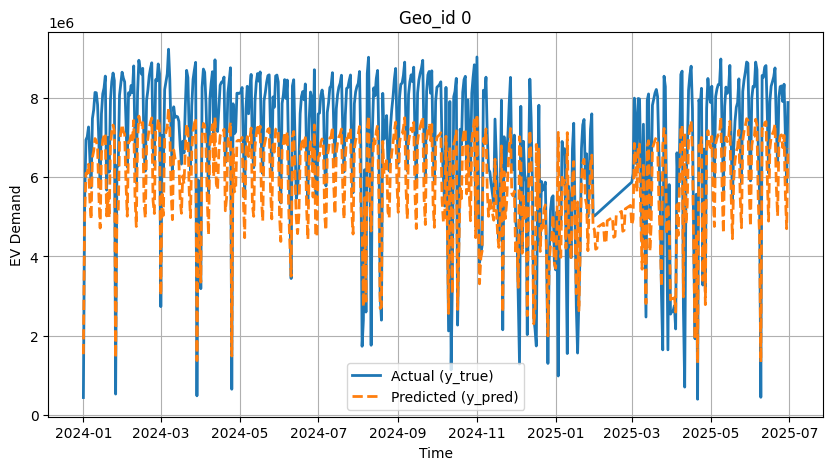

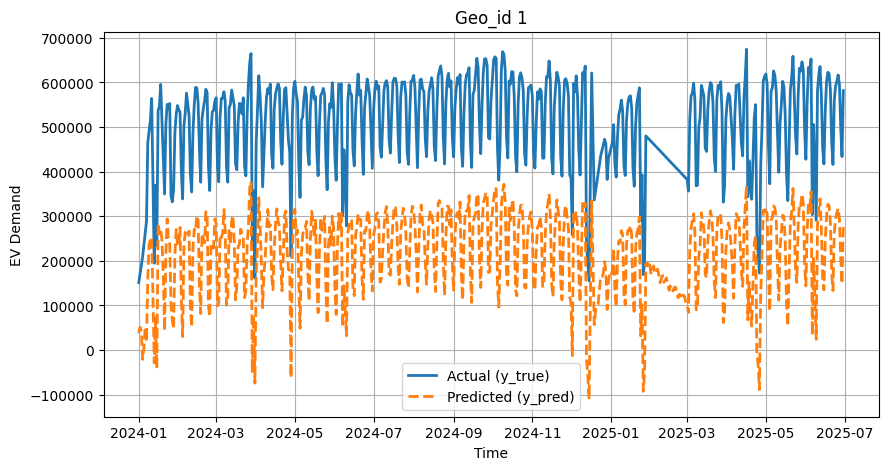

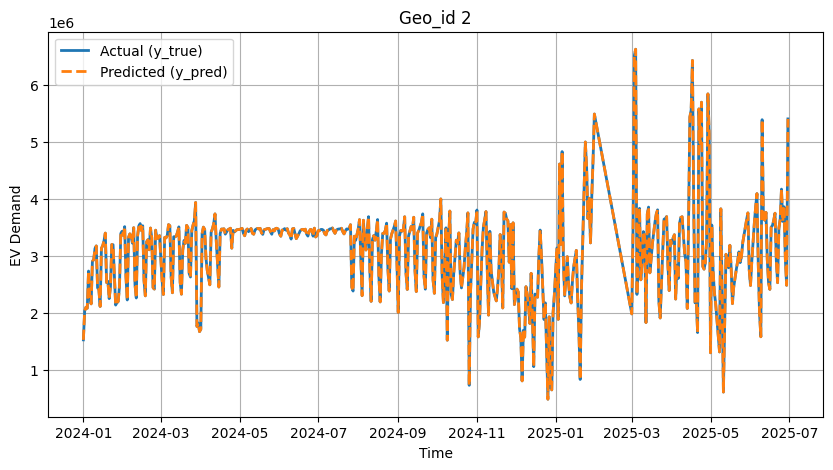

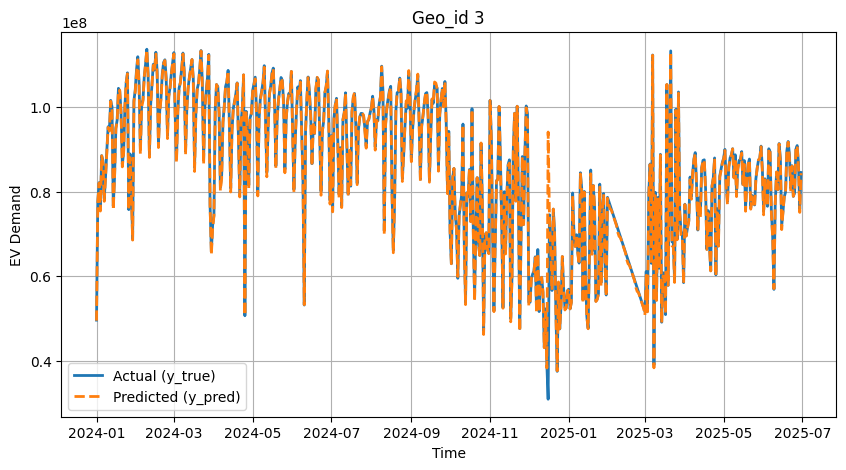

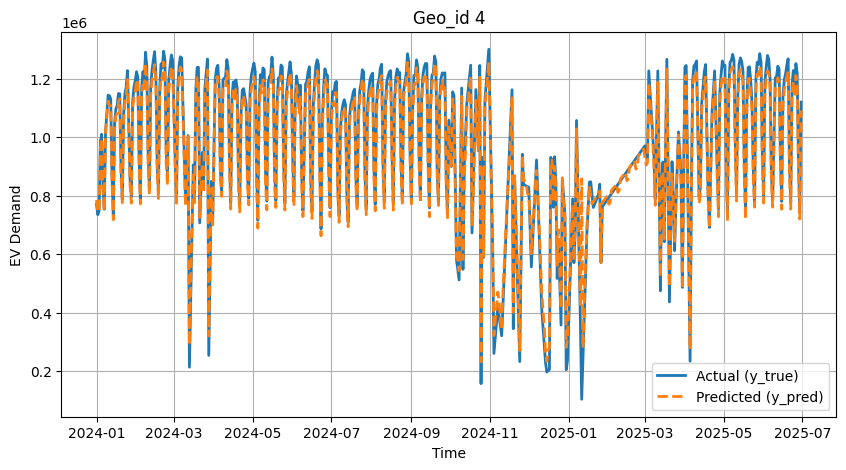

In [ ]:
for geo_id, res in SARIMA_model.items():
    plt.figure(figsize=(10, 5))
    plt.plot(res["y_test"], label="Actual (y_true)", linewidth=2)
    plt.plot(res["predict_EV_demand"], label="Predicted (y_pred)", linewidth=2, linestyle="--")
    plt.title(f"Geo_id {geo_id}")
    plt.xlabel("Time")
    plt.ylabel("EV Demand")
    plt.legend()
    plt.grid(True)
    plt.show()


**4. Bulding the Prophet model for EV Charging Demand Prediction**

- Create a function to split for Prophet model

In [ ]:
start = 2020
end   = 2023

def prophet_split_data(df, start, end, date_col='Date'):
    #Ensure the Date column in right format
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # Create a mask for spliting train and test
    mask_train = df[date_col].dt.year.between(start, end)
    mask_test  = df[date_col].dt.year >= (end + 1)

    train_df = df.loc[mask_train].reset_index(drop=True)
    test_df  = df.loc[mask_test].reset_index(drop=True)
    return train_df, test_df


- Implement the Prophet Model

In [ ]:
exog_cols

['public_holiday',
 'school_holiday',
 'Avg_Temp',
 'Avg_Humidity',
 'Avg_Wind',
 'is_weekend']

In [ ]:
from scipy.stats import uniform

In [ ]:
Prophet_model ={}

for i in geo_number:
  df = geo_clean[geo_clean['geo_cluster'] == i].reset_index().rename(columns={'index': 'Date'})
  df.drop(columns=['geo_cluster'], inplace=True)

  #Split the train_df and test_df for model
  train_df, test_df = prophet_split_data(df, start, end)

  train_df = train_df.rename(columns={'Date':'ds', 'estimated_demand_kWh':'y'})
  test_df  = test_df.rename(columns={'Date':'ds', 'estimated_demand_kWh':'y'})


  #Implement the Prophet model and Add regressor
  prophet_model = Prophet()
  for col in exog_cols:
    prophet_model.add_regressor(col)

  cols_fit = ['ds', 'y'] + exog_cols
  prophet_model.fit(train_df[cols_fit])

  forecast_test = prophet_model.predict(test_df[['ds'] + exog_cols])
  forecast_test = forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

  result_metric = return_metrics(test_df['y'], forecast_test['yhat'])
  mae, mape, rmse = result_metric

  Prophet_model[i] = {
      "geo_id" : i,
      "prophet_model" : prophet_model,
      "mape" :mape,
      "mae" : mae,
      "rmse" : rmse,
      "predict_EV_demand": forecast_test,
      "y_test" : test_df['y'],
  }


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/um74afa4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/laq060zs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51534', 'data', 'file=/tmp/tmpg8geaeth/um74afa4.json', 'init=/tmp/tmpg8geaeth/laq060zs.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelaq6ynjpo/prophet_model-20250918112821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:28:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8

MAE: 3149652.89
MAPE: 88.68%
RMSE: 3878707.320125


11:28:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/uphbs6ud.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/zw3uldc_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66277', 'data', 'file=/tmp/tmpg8geaeth/uphbs6ud.json', 'init=/tmp/tmpg8geaeth/zw3uldc_.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model8tewmb7q/prophet_model-20250918112823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 117420.75
MAPE: 24.16%
RMSE: 134410.767807


11:28:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/77f_s4p4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/xvnh3hp0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57256', 'data', 'file=/tmp/tmpg8geaeth/77f_s4p4.json', 'init=/tmp/tmpg8geaeth/xvnh3hp0.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelol1h827l/prophet_model-20250918112824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 983139.19
MAPE: 32.89%
RMSE: 1272191.804763


11:28:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/wzjttnt4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/egj7y4fw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97138', 'data', 'file=/tmp/tmpg8geaeth/wzjttnt4.json', 'init=/tmp/tmpg8geaeth/egj7y4fw.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model2a2u3fxy/prophet_model-20250918112824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 27806669.33
MAPE: 39.58%
RMSE: 35085049.901507


11:28:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 496425.19
MAPE: 74.91%
RMSE: 595711.203272


In [ ]:
from prophet import Prophet
import itertools
import matplotlib.pyplot as plt

# Hyperparameter grid (you can expand these ranges)
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [1.0, 5.0, 10.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all parameter combinations
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

Prophet_model = {}

for i in geo_number:
    df = geo_clean[geo_clean['geo_cluster'] == i].reset_index().rename(columns={'index': 'Date'})
    df.drop(columns=['geo_cluster'], inplace=True)

    # Split into train/test
    train_df, test_df = prophet_split_data(df, start, end)
    train_df = train_df.rename(columns={'Date':'ds', 'estimated_demand_kWh':'y'})
    test_df  = test_df.rename(columns={'Date':'ds', 'estimated_demand_kWh':'y'})

    best_score, best_params, best_model, best_forecast, best_metrics = float("inf"), None, None, None, None

    # Grid search
    for params in all_params:
        model = Prophet(**params)
        for col in exog_cols:
            model.add_regressor(col)

        cols_fit = ['ds', 'y'] + exog_cols
        model.fit(train_df[cols_fit])

        forecast_test = model.predict(test_df[['ds'] + exog_cols])
        forecast_test = forecast_test[['ds', 'yhat']]

        mae, mape, rmse = return_metrics(test_df['y'], forecast_test['yhat'])

        # Pick the model with lowest MAPE
        if mape < best_score:
            best_score = mape
            best_params = params
            best_model = model
            best_forecast = forecast_test.copy()
            best_metrics = (mae, mape, rmse)

    mae, mape, rmse = best_metrics
    Prophet_model[i] = {
        "geo_id" : i,
        "prophet_model" : best_model,
        "best_params" : best_params,
        "mape" : mape,
        "mae" : mae,
        "rmse" : rmse,
        "y_test" : test_df[['ds','y']],          # actual values
        "y_pred" : best_forecast[['ds','yhat']], # predictions
    }

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/j7hhebza.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/hvup0uhw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46986', 'data', 'file=/tmp/tmpg8geaeth/j7hhebza.json', 'init=/tmp/tmpg8geaeth/hvup0uhw.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelt_v100q7/prophet_model-20250918112849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:28:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8

MAE: 1391071.29
MAPE: 49.87%
RMSE: 2098398.723530


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/s50r4to8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/83olel_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54358', 'data', 'file=/tmp/tmpg8geaeth/s50r4to8.json', 'init=/tmp/tmpg8geaeth/83olel_3.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model6s8eevf9/prophet_model-20250918112850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:28:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 1428553.61
MAPE: 51.81%
RMSE: 2179214.075923


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ik1_ker8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/h8qfevs3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75213', 'data', 'file=/tmp/tmpg8geaeth/ik1_ker8.json', 'init=/tmp/tmpg8geaeth/h8qfevs3.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelc761hkq7/prophet_model-20250918112850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:28:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 1390600.33
MAPE: 49.86%
RMSE: 2096998.411434


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/56mwbqup.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/fjdpg37p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36962', 'data', 'file=/tmp/tmpg8geaeth/56mwbqup.json', 'init=/tmp/tmpg8geaeth/fjdpg37p.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modeltdo3trlv/prophet_model-20250918112850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1427894.17
MAPE: 51.76%
RMSE: 2177401.885914


11:28:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/kg5zv7r6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/c9kbv20r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99251', 'data', 'file=/tmp/tmpg8geaeth/kg5zv7r6.json', 'init=/tmp/tmpg8geaeth/c9kbv20r.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelkff_3nbl/prophet_model-20250918112851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:28:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 1397384.53
MAPE: 50.22%
RMSE: 2111200.365278


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/0ffcnqf6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/q161mfir.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96654', 'data', 'file=/tmp/tmpg8geaeth/0ffcnqf6.json', 'init=/tmp/tmpg8geaeth/q161mfir.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelm9a6rjzb/prophet_model-20250918112851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1427907.58
MAPE: 51.76%
RMSE: 2177367.456242


11:28:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/u4v012zg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/8uauc5bj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42885', 'data', 'file=/tmp/tmpg8geaeth/u4v012zg.json', 'init=/tmp/tmpg8geaeth/8uauc5bj.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelcu4rs9_m/prophet_model-20250918112852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1397279.32
MAPE: 50.22%
RMSE: 2110713.287987


11:28:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/h5hph094.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/xizwgie6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36596', 'data', 'file=/tmp/tmpg8geaeth/h5hph094.json', 'init=/tmp/tmpg8geaeth/xizwgie6.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelvmxs0ovt/prophet_model-20250918112852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1427921.21
MAPE: 51.76%
RMSE: 2177390.916760


11:28:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/869_px1i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ggqw5q41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32299', 'data', 'file=/tmp/tmpg8geaeth/869_px1i.json', 'init=/tmp/tmpg8geaeth/ggqw5q41.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelsoc8qow9/prophet_model-20250918112852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:28:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 1357606.97
MAPE: 47.81%
RMSE: 1999605.632579


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/9nbos4dr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/0dg5cg9c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71032', 'data', 'file=/tmp/tmpg8geaeth/9nbos4dr.json', 'init=/tmp/tmpg8geaeth/0dg5cg9c.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model6ajjcmzd/prophet_model-20250918112853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1381403.48
MAPE: 47.99%
RMSE: 2017541.318683


11:28:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/76ejl_qo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/vg5moyim.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13132', 'data', 'file=/tmp/tmpg8geaeth/76ejl_qo.json', 'init=/tmp/tmpg8geaeth/vg5moyim.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modeleqcudr6m/prophet_model-20250918112853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1356941.60
MAPE: 47.81%
RMSE: 1999190.293780


11:28:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/5uhhpzq4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/9cq6zex9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28984', 'data', 'file=/tmp/tmpg8geaeth/5uhhpzq4.json', 'init=/tmp/tmpg8geaeth/9cq6zex9.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model2b6jx4r5/prophet_model-20250918112854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1379655.24
MAPE: 47.92%
RMSE: 2013964.424278


11:28:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/4cs36k0w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/3eig483k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85686', 'data', 'file=/tmp/tmpg8geaeth/4cs36k0w.json', 'init=/tmp/tmpg8geaeth/3eig483k.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model0zr5b24i/prophet_model-20250918112854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1355470.66
MAPE: 47.84%
RMSE: 2000483.170796


11:28:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/njncnry0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/g5be85uy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53570', 'data', 'file=/tmp/tmpg8geaeth/njncnry0.json', 'init=/tmp/tmpg8geaeth/g5be85uy.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modeli2z90o4f/prophet_model-20250918112854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1379579.46
MAPE: 47.92%
RMSE: 2013725.694906


11:28:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/orqpe_8b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/t9eb9wp0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26202', 'data', 'file=/tmp/tmpg8geaeth/orqpe_8b.json', 'init=/tmp/tmpg8geaeth/t9eb9wp0.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelz17ixn0u/prophet_model-20250918112855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1355605.42
MAPE: 47.63%
RMSE: 1991715.073721


11:28:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/co30dtm0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/l26_w79z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51542', 'data', 'file=/tmp/tmpg8geaeth/co30dtm0.json', 'init=/tmp/tmpg8geaeth/l26_w79z.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modela5nyvx4p/prophet_model-20250918112855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1380054.16
MAPE: 47.95%
RMSE: 2015439.531303


11:28:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ojipuxx5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/qtp0v7cj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11792', 'data', 'file=/tmp/tmpg8geaeth/ojipuxx5.json', 'init=/tmp/tmpg8geaeth/qtp0v7cj.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelzwg3lfuh/prophet_model-20250918112856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 3591856.16
MAPE: 97.34%
RMSE: 4292869.171151


11:28:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/jtx00rq5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/e64uileh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50933', 'data', 'file=/tmp/tmpg8geaeth/jtx00rq5.json', 'init=/tmp/tmpg8geaeth/e64uileh.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelspjul7xo/prophet_model-20250918112857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 4067125.47
MAPE: 105.35%
RMSE: 4856737.652649


11:28:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ev3t9ors.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/tgqok2b2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81684', 'data', 'file=/tmp/tmpg8geaeth/ev3t9ors.json', 'init=/tmp/tmpg8geaeth/tgqok2b2.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelxjtoeyp9/prophet_model-20250918112857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 3607927.15
MAPE: 97.67%
RMSE: 4309613.419158


11:28:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/9m230bae.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/_tamowd3.json


MAE: 3560277.86
MAPE: 95.46%
RMSE: 4333072.464308


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8773', 'data', 'file=/tmp/tmpg8geaeth/9m230bae.json', 'init=/tmp/tmpg8geaeth/_tamowd3.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model6w3wh4xz/prophet_model-20250918112859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:28:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:28:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/2eg0wm57.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/jgd__2o6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-package

MAE: 3612520.31
MAPE: 97.75%
RMSE: 4312649.579550


INFO:cmdstanpy:Chain [1] start processing
11:29:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ephdpzkj.json


MAE: 3759300.85
MAPE: 99.36%
RMSE: 4538644.477716


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/2h85hp71.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46704', 'data', 'file=/tmp/tmpg8geaeth/ephdpzkj.json', 'init=/tmp/tmpg8geaeth/2h85hp71.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model_nuqx1eg/prophet_model-20250918112901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:29:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/t3z7wcla.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/78qdt7kb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

MAE: 3580531.79
MAPE: 97.13%
RMSE: 4282538.628659


11:29:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/nxebonum.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/dck0kcpk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26920', 'data', 'file=/tmp/tmpg8geaeth/nxebonum.json', 'init=/tmp/tmpg8geaeth/dck0kcpk.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model_h5f73el/prophet_model-20250918112903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 2924663.98
MAPE: 82.96%
RMSE: 3678877.876521


11:29:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/9bl5t0rt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/18h74ild.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54613', 'data', 'file=/tmp/tmpg8geaeth/9bl5t0rt.json', 'init=/tmp/tmpg8geaeth/18h74ild.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelffmdfa7m/prophet_model-20250918112904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1969505.61
MAPE: 64.65%
RMSE: 2717886.115248


11:29:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/s4i0ekhu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/db35dvb5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19530', 'data', 'file=/tmp/tmpg8geaeth/s4i0ekhu.json', 'init=/tmp/tmpg8geaeth/db35dvb5.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelo19or7sh/prophet_model-20250918112905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1663150.95
MAPE: 56.99%
RMSE: 2404624.943263


11:29:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/2immftlm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/5wjlnn5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43604', 'data', 'file=/tmp/tmpg8geaeth/2immftlm.json', 'init=/tmp/tmpg8geaeth/5wjlnn5q.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelz70nb05g/prophet_model-20250918112906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1909565.02
MAPE: 63.40%
RMSE: 2661642.272915


11:29:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ldoyet_d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/svm_9dn2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34982', 'data', 'file=/tmp/tmpg8geaeth/ldoyet_d.json', 'init=/tmp/tmpg8geaeth/svm_9dn2.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelxjh_5cel/prophet_model-20250918112908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1365069.14
MAPE: 50.39%
RMSE: 2119771.798891


11:29:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/fki_z_b8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/t3p0365q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76623', 'data', 'file=/tmp/tmpg8geaeth/fki_z_b8.json', 'init=/tmp/tmpg8geaeth/t3p0365q.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model89khcjg1/prophet_model-20250918112909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1922297.94
MAPE: 63.66%
RMSE: 2672719.838807


11:29:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/3ei_qkj5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/i0qy6jzv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1650', 'data', 'file=/tmp/tmpg8geaeth/3ei_qkj5.json', 'init=/tmp/tmpg8geaeth/i0qy6jzv.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelwaxa7cis/prophet_model-20250918112911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1282444.92
MAPE: 48.31%
RMSE: 2029726.111380


11:29:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/7qapkh4r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/lif6m6vx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33106', 'data', 'file=/tmp/tmpg8geaeth/7qapkh4r.json', 'init=/tmp/tmpg8geaeth/lif6m6vx.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model4bhgbgo3/prophet_model-20250918112911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1943155.68
MAPE: 64.08%
RMSE: 2692048.883413


11:29:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/q_qe0hcu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/4l763gcr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62001', 'data', 'file=/tmp/tmpg8geaeth/q_qe0hcu.json', 'init=/tmp/tmpg8geaeth/4l763gcr.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelcq2jlgy4/prophet_model-20250918112915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1262568.42
MAPE: 47.65%
RMSE: 1996471.718829


11:29:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ymigmme9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/0qrji79r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20086', 'data', 'file=/tmp/tmpg8geaeth/ymigmme9.json', 'init=/tmp/tmpg8geaeth/0qrji79r.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model9blqpeji/prophet_model-20250918112916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 113940.92
MAPE: 23.65%
RMSE: 130373.479348


11:29:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/rica2t9j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/536nq7rd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46468', 'data', 'file=/tmp/tmpg8geaeth/rica2t9j.json', 'init=/tmp/tmpg8geaeth/536nq7rd.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modeled8jwebs/prophet_model-20250918112916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 195775.14
MAPE: 38.43%
RMSE: 206962.547924


11:29:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/43ufxkol.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/fdhlbkvd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43040', 'data', 'file=/tmp/tmpg8geaeth/43ufxkol.json', 'init=/tmp/tmpg8geaeth/fdhlbkvd.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model50nd5noi/prophet_model-20250918112917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 125880.94
MAPE: 25.59%
RMSE: 142232.119451


11:29:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/1p0w34wx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/jcib1dfy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93694', 'data', 'file=/tmp/tmpg8geaeth/1p0w34wx.json', 'init=/tmp/tmpg8geaeth/jcib1dfy.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelr692cg9n/prophet_model-20250918112917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 196084.79
MAPE: 38.49%
RMSE: 207269.821194


11:29:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ze90wpcp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/fknt182p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2608', 'data', 'file=/tmp/tmpg8geaeth/ze90wpcp.json', 'init=/tmp/tmpg8geaeth/fknt182p.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelc80tis_q/prophet_model-20250918112918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 126848.50
MAPE: 25.74%
RMSE: 143276.611420


11:29:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/2vma9z8l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/by3_u85v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82196', 'data', 'file=/tmp/tmpg8geaeth/2vma9z8l.json', 'init=/tmp/tmpg8geaeth/by3_u85v.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelsyh5qrbn/prophet_model-20250918112918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 191766.44
MAPE: 37.72%
RMSE: 202866.457858


11:29:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/hqwgvixg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/3qu7iuna.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73703', 'data', 'file=/tmp/tmpg8geaeth/hqwgvixg.json', 'init=/tmp/tmpg8geaeth/3qu7iuna.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modeloqvod_mu/prophet_model-20250918112918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 126558.83
MAPE: 25.71%
RMSE: 142864.364424


11:29:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/4x_2oi_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/l7qjywrc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93162', 'data', 'file=/tmp/tmpg8geaeth/4x_2oi_b.json', 'init=/tmp/tmpg8geaeth/l7qjywrc.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model8qbwp5ej/prophet_model-20250918112919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:29:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 186316.39
MAPE: 36.74%
RMSE: 197377.075127


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/keb4chsl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ftku_0b3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63262', 'data', 'file=/tmp/tmpg8geaeth/keb4chsl.json', 'init=/tmp/tmpg8geaeth/ftku_0b3.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelphyejyym/prophet_model-20250918112919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 84261.80
MAPE: 18.53%
RMSE: 103921.941687


11:29:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/7mznt5jz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/40tj1jrb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34327', 'data', 'file=/tmp/tmpg8geaeth/7mznt5jz.json', 'init=/tmp/tmpg8geaeth/40tj1jrb.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelcli9ff2o/prophet_model-20250918112920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 75750.42
MAPE: 17.24%
RMSE: 99219.757214


11:29:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/api9lk2t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/m8ekd_k6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78815', 'data', 'file=/tmp/tmpg8geaeth/api9lk2t.json', 'init=/tmp/tmpg8geaeth/m8ekd_k6.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modeljayhhopi/prophet_model-20250918112920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 89449.88
MAPE: 19.38%
RMSE: 108058.133337


11:29:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/jp_d9eyr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/68wu3m9t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3021', 'data', 'file=/tmp/tmpg8geaeth/jp_d9eyr.json', 'init=/tmp/tmpg8geaeth/68wu3m9t.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modeldapsxh3c/prophet_model-20250918112920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 74164.00
MAPE: 17.01%
RMSE: 98172.567488


11:29:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/nys9jiur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/cpybgqr5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20818', 'data', 'file=/tmp/tmpg8geaeth/nys9jiur.json', 'init=/tmp/tmpg8geaeth/cpybgqr5.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model1kn_ptfd/prophet_model-20250918112921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 88857.52
MAPE: 19.29%
RMSE: 107626.748534


11:29:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/f8c69n9w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/fc1irtwz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98480', 'data', 'file=/tmp/tmpg8geaeth/f8c69n9w.json', 'init=/tmp/tmpg8geaeth/fc1irtwz.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelq9hpm33y/prophet_model-20250918112921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:29:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 75455.36
MAPE: 17.19%
RMSE: 98925.242830


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ii2juuoc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/g73a4qqi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4368', 'data', 'file=/tmp/tmpg8geaeth/ii2juuoc.json', 'init=/tmp/tmpg8geaeth/g73a4qqi.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model5o3s1qmp/prophet_model-20250918112922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 92993.64
MAPE: 19.94%
RMSE: 110777.333368


11:29:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/kld92io8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/by40y5o3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76809', 'data', 'file=/tmp/tmpg8geaeth/kld92io8.json', 'init=/tmp/tmpg8geaeth/by40y5o3.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelw2xl33tf/prophet_model-20250918112922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 72588.32
MAPE: 16.80%
RMSE: 97412.439690


11:29:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ja28ruqt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/jdzmv4b7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44979', 'data', 'file=/tmp/tmpg8geaeth/ja28ruqt.json', 'init=/tmp/tmpg8geaeth/jdzmv4b7.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelox4va6eh/prophet_model-20250918112923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 220403.75
MAPE: 43.49%
RMSE: 239520.229446


11:29:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/h7o16bco.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/n__fqajj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14209', 'data', 'file=/tmp/tmpg8geaeth/h7o16bco.json', 'init=/tmp/tmpg8geaeth/n__fqajj.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelzyadzdgd/prophet_model-20250918112924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1051053.43
MAPE: 209.73%
RMSE: 1123706.166365


11:29:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/kbpm64b5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/r28mc33q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56732', 'data', 'file=/tmp/tmpg8geaeth/kbpm64b5.json', 'init=/tmp/tmpg8geaeth/r28mc33q.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelgzzur1p8/prophet_model-20250918112925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 214182.73
MAPE: 42.28%
RMSE: 233190.920179


11:29:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/_rcxlap4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/96q283dy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61313', 'data', 'file=/tmp/tmpg8geaeth/_rcxlap4.json', 'init=/tmp/tmpg8geaeth/96q283dy.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modellueqctu3/prophet_model-20250918112928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1134980.09
MAPE: 226.41%
RMSE: 1219348.222836


11:29:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/az0wyj4k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/0c41cxh9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15091', 'data', 'file=/tmp/tmpg8geaeth/az0wyj4k.json', 'init=/tmp/tmpg8geaeth/0c41cxh9.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model266fp8j8/prophet_model-20250918112928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 222761.46
MAPE: 43.96%
RMSE: 242074.027709


11:29:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/0lfsuijl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/s8scgnyk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16577', 'data', 'file=/tmp/tmpg8geaeth/0lfsuijl.json', 'init=/tmp/tmpg8geaeth/s8scgnyk.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model3u7nov0q/prophet_model-20250918112932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1123949.70
MAPE: 224.15%
RMSE: 1206879.882585


11:29:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/apj_fe72.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/jv1c6gxt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17008', 'data', 'file=/tmp/tmpg8geaeth/apj_fe72.json', 'init=/tmp/tmpg8geaeth/jv1c6gxt.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelgcj9wqr2/prophet_model-20250918112932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 211206.63
MAPE: 41.70%
RMSE: 230217.778917


11:29:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/rzb61fd8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/y3qdhsgh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98516', 'data', 'file=/tmp/tmpg8geaeth/rzb61fd8.json', 'init=/tmp/tmpg8geaeth/y3qdhsgh.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelv0hg7vrd/prophet_model-20250918112934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1154414.83
MAPE: 230.26%
RMSE: 1241962.382693


11:29:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/kxqg0jt1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/275ool_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61910', 'data', 'file=/tmp/tmpg8geaeth/kxqg0jt1.json', 'init=/tmp/tmpg8geaeth/275ool_d.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelx9foe90r/prophet_model-20250918112936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 895235.72
MAPE: 184.57%
RMSE: 947444.762144


11:29:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/o_sm16he.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/l_96b7c5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=363', 'data', 'file=/tmp/tmpg8geaeth/o_sm16he.json', 'init=/tmp/tmpg8geaeth/l_96b7c5.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model9yfzds9z/prophet_model-20250918112937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1167507.31
MAPE: 232.80%
RMSE: 1257482.146474


11:29:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/jwxgt1rn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/7kp9ddw_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80273', 'data', 'file=/tmp/tmpg8geaeth/jwxgt1rn.json', 'init=/tmp/tmpg8geaeth/7kp9ddw_.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model_uyy5qbf/prophet_model-20250918112938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 900724.01
MAPE: 185.75%
RMSE: 953299.751770


11:29:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ynaitzt4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/iaw27ogt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44009', 'data', 'file=/tmp/tmpg8geaeth/ynaitzt4.json', 'init=/tmp/tmpg8geaeth/iaw27ogt.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelugkeksyb/prophet_model-20250918112941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1179364.54
MAPE: 235.06%
RMSE: 1272207.660188


11:29:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/rywhtada.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/b0u5lrdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98047', 'data', 'file=/tmp/tmpg8geaeth/rywhtada.json', 'init=/tmp/tmpg8geaeth/b0u5lrdp.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelmh9tp0qf/prophet_model-20250918112943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 906336.62
MAPE: 186.88%
RMSE: 959362.627143


11:29:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/jpqdqphv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/f9167v32.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54857', 'data', 'file=/tmp/tmpg8geaeth/jpqdqphv.json', 'init=/tmp/tmpg8geaeth/f9167v32.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelstyxoglw/prophet_model-20250918112946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1192941.46
MAPE: 237.76%
RMSE: 1288352.110529


11:29:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/a60g2her.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/jdfqvm7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66321', 'data', 'file=/tmp/tmpg8geaeth/a60g2her.json', 'init=/tmp/tmpg8geaeth/jdfqvm7j.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model39eo5dxe/prophet_model-20250918112947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 891381.64
MAPE: 183.76%
RMSE: 943402.629239


11:29:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/uhtpp162.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/naqp8vhg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97634', 'data', 'file=/tmp/tmpg8geaeth/uhtpp162.json', 'init=/tmp/tmpg8geaeth/naqp8vhg.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelzeg750l8/prophet_model-20250918112950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1187192.47
MAPE: 236.58%
RMSE: 1281775.814817


11:29:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/dne58763.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/na05giwl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47924', 'data', 'file=/tmp/tmpg8geaeth/dne58763.json', 'init=/tmp/tmpg8geaeth/na05giwl.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelp427ie6_/prophet_model-20250918112950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 810378.44
MAPE: 31.47%
RMSE: 1031893.827505


11:29:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/4yhv13zl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/3z1i_ooc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14314', 'data', 'file=/tmp/tmpg8geaeth/4yhv13zl.json', 'init=/tmp/tmpg8geaeth/3z1i_ooc.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_models3ett5g_/prophet_model-20250918112951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:29:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 669114.17
MAPE: 26.96%
RMSE: 896642.790729


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/37v9csiv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/poc7qswa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51359', 'data', 'file=/tmp/tmpg8geaeth/37v9csiv.json', 'init=/tmp/tmpg8geaeth/poc7qswa.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelc49s9t2o/prophet_model-20250918112951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:29:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 816001.89
MAPE: 31.73%
RMSE: 1037318.330294


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/xtq8t79v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ezkltiq8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54150', 'data', 'file=/tmp/tmpg8geaeth/xtq8t79v.json', 'init=/tmp/tmpg8geaeth/ezkltiq8.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelj3lvl5ia/prophet_model-20250918112952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 665160.84
MAPE: 26.69%
RMSE: 892565.989266


11:29:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/u_j3xt7r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/mqvi3wpz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58266', 'data', 'file=/tmp/tmpg8geaeth/u_j3xt7r.json', 'init=/tmp/tmpg8geaeth/mqvi3wpz.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelc3jdmhu2/prophet_model-20250918112952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:29:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 815215.30
MAPE: 31.70%
RMSE: 1036555.349018


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/9or75hdg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/n6nwvl39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16405', 'data', 'file=/tmp/tmpg8geaeth/9or75hdg.json', 'init=/tmp/tmpg8geaeth/n6nwvl39.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelr41xmn8g/prophet_model-20250918112952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 665026.26
MAPE: 26.69%
RMSE: 892491.151305


11:29:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/zny64ncz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/466zmzby.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90975', 'data', 'file=/tmp/tmpg8geaeth/zny64ncz.json', 'init=/tmp/tmpg8geaeth/466zmzby.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model7i5f3vem/prophet_model-20250918112953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 814906.87
MAPE: 31.68%
RMSE: 1036257.114350


11:29:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/mm9lagck.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/3gs2se8k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31430', 'data', 'file=/tmp/tmpg8geaeth/mm9lagck.json', 'init=/tmp/tmpg8geaeth/3gs2se8k.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelju156z04/prophet_model-20250918112953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 665959.70
MAPE: 26.71%
RMSE: 893303.331557


11:29:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/tweh4pfu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/7pxjfyyf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25698', 'data', 'file=/tmp/tmpg8geaeth/tweh4pfu.json', 'init=/tmp/tmpg8geaeth/7pxjfyyf.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelwh0craoe/prophet_model-20250918112954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 795089.17
MAPE: 29.19%
RMSE: 1036128.304353


11:29:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/jwy908_d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/68np8zn7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59763', 'data', 'file=/tmp/tmpg8geaeth/jwy908_d.json', 'init=/tmp/tmpg8geaeth/68np8zn7.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelbl60dzti/prophet_model-20250918112955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:55 - cmdstanpy - INFO - Chain [1] start processing


MAE: 703988.32
MAPE: 25.57%
RMSE: 945482.828047


INFO:cmdstanpy:Chain [1] start processing
11:29:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/mz2uxlgm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/9xo9b932.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35911', 'data', 'file=/tmp/tmpg8geaeth/mz2uxlgm.json', 'init=/tmp/tmpg8geaeth/9xo9b932.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelfjb43qmf/prophet_model-20250918112955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 795735.55
MAPE: 29.20%
RMSE: 1037248.255133


11:29:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/b6wmybtd.json


MAE: 700020.81
MAPE: 25.55%
RMSE: 940656.694968


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/veqn3bwg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57313', 'data', 'file=/tmp/tmpg8geaeth/b6wmybtd.json', 'init=/tmp/tmpg8geaeth/veqn3bwg.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model7dvg4l0r/prophet_model-20250918112956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:29:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/3mgeyea8.json


MAE: 793227.14
MAPE: 29.21%
RMSE: 1032968.591721


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/e1kzmbp2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14588', 'data', 'file=/tmp/tmpg8geaeth/3mgeyea8.json', 'init=/tmp/tmpg8geaeth/e1kzmbp2.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelwdns5sc6/prophet_model-20250918112957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:29:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/74vyfaa2.json


MAE: 700387.78
MAPE: 25.54%
RMSE: 941148.021675


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/4_613r8c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23545', 'data', 'file=/tmp/tmpg8geaeth/74vyfaa2.json', 'init=/tmp/tmpg8geaeth/4_613r8c.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelzy12vube/prophet_model-20250918112958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:29:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/oe18p9xn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/o0ytclh6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

MAE: 793342.69
MAPE: 29.22%
RMSE: 1033224.967511


11:29:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/c9s7uv6r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/nd4o8x0_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41977', 'data', 'file=/tmp/tmpg8geaeth/c9s7uv6r.json', 'init=/tmp/tmpg8geaeth/nd4o8x0_.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model23ewwkgv/prophet_model-20250918112959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 699336.52
MAPE: 25.53%
RMSE: 939967.768181


11:29:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/tiyx6wik.json


MAE: 1056353.62
MAPE: 34.72%
RMSE: 1356859.004692


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/_v6caq71.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6606', 'data', 'file=/tmp/tmpg8geaeth/tiyx6wik.json', 'init=/tmp/tmpg8geaeth/_v6caq71.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modeld0hk8rnf/prophet_model-20250918113001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/i4vzkbxo.json


MAE: 1216283.64
MAPE: 37.81%
RMSE: 1494482.403005


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/543i4hi9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18180', 'data', 'file=/tmp/tmpg8geaeth/i4vzkbxo.json', 'init=/tmp/tmpg8geaeth/543i4hi9.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model2ng27vgm/prophet_model-20250918113004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ll0b1z5b.json


MAE: 1051807.32
MAPE: 34.60%
RMSE: 1351867.368252


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/810too6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56485', 'data', 'file=/tmp/tmpg8geaeth/ll0b1z5b.json', 'init=/tmp/tmpg8geaeth/810too6h.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model10shbqmm/prophet_model-20250918113004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/2dit02zf.json


MAE: 1261292.99
MAPE: 39.10%
RMSE: 1541464.683661


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/zs6n5obe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81063', 'data', 'file=/tmp/tmpg8geaeth/2dit02zf.json', 'init=/tmp/tmpg8geaeth/zs6n5obe.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model4pu8hhdo/prophet_model-20250918113005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/d1t39e6t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/tsoa22x4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

MAE: 1052813.70
MAPE: 34.63%
RMSE: 1352531.294873


11:30:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ipork255.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/retkmkgs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63581', 'data', 'file=/tmp/tmpg8geaeth/ipork255.json', 'init=/tmp/tmpg8geaeth/retkmkgs.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelrnx2lbj3/prophet_model-20250918113006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1254789.98
MAPE: 38.91%
RMSE: 1534375.611378


11:30:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/6e3wv3s8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/5srtg1c4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19540', 'data', 'file=/tmp/tmpg8geaeth/6e3wv3s8.json', 'init=/tmp/tmpg8geaeth/5srtg1c4.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelifzh3eub/prophet_model-20250918113007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 1044770.74
MAPE: 34.42%
RMSE: 1343567.781211


11:30:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/l0g6q6jo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ca_3x59y.json
DEBUG:cmdstanpy:idx 0


MAE: 1227268.65
MAPE: 38.12%
RMSE: 1505880.254048


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71178', 'data', 'file=/tmp/tmpg8geaeth/l0g6q6jo.json', 'init=/tmp/tmpg8geaeth/ca_3x59y.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelitm2g34g/prophet_model-20250918113008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/9ptvqfrq.json


MAE: 3437010.00
MAPE: 113.87%
RMSE: 3849346.395186


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/04lqp0pn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74593', 'data', 'file=/tmp/tmpg8geaeth/9ptvqfrq.json', 'init=/tmp/tmpg8geaeth/04lqp0pn.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modellbpkkom0/prophet_model-20250918113011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/pxcjffm5.json


MAE: 3070137.17
MAPE: 99.58%
RMSE: 3387735.037370


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/anrvgslg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49277', 'data', 'file=/tmp/tmpg8geaeth/pxcjffm5.json', 'init=/tmp/tmpg8geaeth/anrvgslg.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model910epivf/prophet_model-20250918113013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/1oc_kgz_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/vs9roxff.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

MAE: 3582477.41
MAPE: 118.92%
RMSE: 4002288.813242


11:30:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/s3xue84b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/xy7apani.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80079', 'data', 'file=/tmp/tmpg8geaeth/s3xue84b.json', 'init=/tmp/tmpg8geaeth/xy7apani.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelj13lexe5/prophet_model-20250918113016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 3172651.26
MAPE: 103.19%
RMSE: 3493539.875961


11:30:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/wagwncua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/d8sio49v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46831', 'data', 'file=/tmp/tmpg8geaeth/wagwncua.json', 'init=/tmp/tmpg8geaeth/d8sio49v.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelbw0qsz29/prophet_model-20250918113017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 3389063.55
MAPE: 112.19%
RMSE: 3799277.466516


11:30:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/e9rtd7nm.json


MAE: 3099028.53
MAPE: 100.57%
RMSE: 3427226.300913


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/__4rx6vi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28398', 'data', 'file=/tmp/tmpg8geaeth/e9rtd7nm.json', 'init=/tmp/tmpg8geaeth/__4rx6vi.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelk09l13_r/prophet_model-20250918113022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/wyaoohxd.json


MAE: 3305501.39
MAPE: 109.29%
RMSE: 3711735.097978


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/58yjvwg4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75679', 'data', 'file=/tmp/tmpg8geaeth/wyaoohxd.json', 'init=/tmp/tmpg8geaeth/58yjvwg4.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelv7sylo6c/prophet_model-20250918113024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/vqu1qq7y.json


MAE: 3040772.47
MAPE: 98.51%
RMSE: 3363893.752752


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/a0ml1zbc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2218', 'data', 'file=/tmp/tmpg8geaeth/vqu1qq7y.json', 'init=/tmp/tmpg8geaeth/a0ml1zbc.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modell1t3hd49/prophet_model-20250918113029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/3jn2bxjh.json


MAE: 20266163.94
MAPE: 29.51%
RMSE: 26960725.502044


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/kek4kuic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85582', 'data', 'file=/tmp/tmpg8geaeth/3jn2bxjh.json', 'init=/tmp/tmpg8geaeth/kek4kuic.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelrctsdyb2/prophet_model-20250918113030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/5wy7_hz1.json


MAE: 21402156.02
MAPE: 30.91%
RMSE: 28283615.417693


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/lj861rxd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94401', 'data', 'file=/tmp/tmpg8geaeth/5wy7_hz1.json', 'init=/tmp/tmpg8geaeth/lj861rxd.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelwh3yspos/prophet_model-20250918113031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/w8ja5n2w.json


MAE: 20158046.33
MAPE: 29.35%
RMSE: 26788764.570378


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/z9f6m18r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82162', 'data', 'file=/tmp/tmpg8geaeth/w8ja5n2w.json', 'init=/tmp/tmpg8geaeth/z9f6m18r.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelyeygp8uv/prophet_model-20250918113032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/1v33mkru.json


MAE: 21345834.29
MAPE: 30.84%
RMSE: 28223501.890859


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/sjvbidao.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9926', 'data', 'file=/tmp/tmpg8geaeth/1v33mkru.json', 'init=/tmp/tmpg8geaeth/sjvbidao.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelpna2n_px/prophet_model-20250918113032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/3acn4sxo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/fyjlq335.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

MAE: 20299985.66
MAPE: 29.55%
RMSE: 26944388.524796


11:30:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/apdd3n03.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/grqazbf4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80257', 'data', 'file=/tmp/tmpg8geaeth/apdd3n03.json', 'init=/tmp/tmpg8geaeth/grqazbf4.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelwjd14zm4/prophet_model-20250918113033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 21103213.40
MAPE: 30.51%
RMSE: 27965736.170704


11:30:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/9rn7i_qw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/zq7mwkbo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68888', 'data', 'file=/tmp/tmpg8geaeth/9rn7i_qw.json', 'init=/tmp/tmpg8geaeth/zq7mwkbo.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelrijxyiv5/prophet_model-20250918113034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 20162407.67
MAPE: 29.37%
RMSE: 26787707.210335


11:30:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/b56itkdu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/sd6jcuu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30430', 'data', 'file=/tmp/tmpg8geaeth/b56itkdu.json', 'init=/tmp/tmpg8geaeth/sd6jcuu6.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modeluiv_wns4/prophet_model-20250918113034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 21655477.82
MAPE: 31.25%
RMSE: 28547523.601797


11:30:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ix2udnlo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/oa84s45e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90999', 'data', 'file=/tmp/tmpg8geaeth/ix2udnlo.json', 'init=/tmp/tmpg8geaeth/oa84s45e.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelmhr0kgd3/prophet_model-20250918113035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 18249531.41
MAPE: 26.61%
RMSE: 24610467.867020


11:30:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/f_1gi4gg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/i8suyf7q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44497', 'data', 'file=/tmp/tmpg8geaeth/f_1gi4gg.json', 'init=/tmp/tmpg8geaeth/i8suyf7q.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelxh0o2pwc/prophet_model-20250918113035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 17902209.06
MAPE: 26.01%
RMSE: 24145221.083302


11:30:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/o720j741.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/zf_hdc8h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60407', 'data', 'file=/tmp/tmpg8geaeth/o720j741.json', 'init=/tmp/tmpg8geaeth/zf_hdc8h.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model96d4x49k/prophet_model-20250918113036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 18555306.26
MAPE: 27.07%
RMSE: 25000515.139768


11:30:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/dors8g_r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/324zn4eh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66142', 'data', 'file=/tmp/tmpg8geaeth/dors8g_r.json', 'init=/tmp/tmpg8geaeth/324zn4eh.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelp8g_1m_x/prophet_model-20250918113036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:36 - cmdstanpy - INFO - Chain [1] start processing


MAE: 17556099.49
MAPE: 25.50%
RMSE: 23681223.982996


INFO:cmdstanpy:Chain [1] start processing
11:30:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/jr1x_kkq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/7tc4l78j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51260', 'data', 'file=/tmp/tmpg8geaeth/jr1x_kkq.json', 'init=/tmp/tmpg8geaeth/7tc4l78j.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model8r72aa8q/prophet_model-20250918113037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 18347600.05
MAPE: 26.77%
RMSE: 24752230.796453


11:30:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/mhcjm02u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/9b1vla52.json


MAE: 17672108.42
MAPE: 25.66%
RMSE: 23831574.214216


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89443', 'data', 'file=/tmp/tmpg8geaeth/mhcjm02u.json', 'init=/tmp/tmpg8geaeth/9b1vla52.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelujtv_s3j/prophet_model-20250918113038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/xyuc_5py.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/j4hu3ghb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packag

MAE: 18563813.63
MAPE: 27.08%
RMSE: 25018056.819551


11:30:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/3_4tskd9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/n0uykzp4.json
DEBUG:cmdstanpy:idx 0


MAE: 17590587.72
MAPE: 25.55%
RMSE: 23727841.446523


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71776', 'data', 'file=/tmp/tmpg8geaeth/3_4tskd9.json', 'init=/tmp/tmpg8geaeth/n0uykzp4.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelva5uthnx/prophet_model-20250918113039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/9cwa6kvc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/7e98fwn4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/

MAE: 31263882.40
MAPE: 44.05%
RMSE: 38506625.951636


11:30:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/kncyevsl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/tatcnmgo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37246', 'data', 'file=/tmp/tmpg8geaeth/kncyevsl.json', 'init=/tmp/tmpg8geaeth/tatcnmgo.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelibythdv7/prophet_model-20250918113041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 13453686.19
MAPE: 19.51%
RMSE: 18334569.270673


11:30:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/n98ctnnx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/4p25iprc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60727', 'data', 'file=/tmp/tmpg8geaeth/n98ctnnx.json', 'init=/tmp/tmpg8geaeth/4p25iprc.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelfybvpxo5/prophet_model-20250918113042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 31290269.39
MAPE: 44.09%
RMSE: 38542034.939179


11:30:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/rmwe3hl6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/t7hr3dn3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51049', 'data', 'file=/tmp/tmpg8geaeth/rmwe3hl6.json', 'init=/tmp/tmpg8geaeth/t7hr3dn3.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modeleajr1849/prophet_model-20250918113044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 14385437.89
MAPE: 21.05%
RMSE: 19835992.967254


11:30:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/7u8rn1fc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/xhv1o494.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42661', 'data', 'file=/tmp/tmpg8geaeth/7u8rn1fc.json', 'init=/tmp/tmpg8geaeth/xhv1o494.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelk3brc79p/prophet_model-20250918113045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 30787353.86
MAPE: 43.43%
RMSE: 38036061.201139


11:30:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/41yymxoa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/2ycibpev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10562', 'data', 'file=/tmp/tmpg8geaeth/41yymxoa.json', 'init=/tmp/tmpg8geaeth/2ycibpev.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelzzrvrqxq/prophet_model-20250918113047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 14194573.06
MAPE: 20.76%
RMSE: 19561608.394150


11:30:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/2xkhrcjp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/od30wgyb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80892', 'data', 'file=/tmp/tmpg8geaeth/2xkhrcjp.json', 'init=/tmp/tmpg8geaeth/od30wgyb.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelisar3jks/prophet_model-20250918113047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 31188040.03
MAPE: 43.95%
RMSE: 38435902.142844


11:30:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/knoptvtc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/2dqf0v5f.json


MAE: 13294380.05
MAPE: 19.25%
RMSE: 18103092.361602


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27738', 'data', 'file=/tmp/tmpg8geaeth/knoptvtc.json', 'init=/tmp/tmpg8geaeth/2dqf0v5f.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model6sl1s9sl/prophet_model-20250918113050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/lad78wgy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/97ce7uxi.json


MAE: 13955945.25
MAPE: 20.33%
RMSE: 19156935.850384


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54166', 'data', 'file=/tmp/tmpg8geaeth/lad78wgy.json', 'init=/tmp/tmpg8geaeth/97ce7uxi.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelw5ax7_pw/prophet_model-20250918113051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/pzk0vh4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/0b5uq72l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packag

MAE: 14380946.56
MAPE: 21.06%
RMSE: 19783589.209884


11:30:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/utjl499f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/m1wui1xy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34499', 'data', 'file=/tmp/tmpg8geaeth/utjl499f.json', 'init=/tmp/tmpg8geaeth/m1wui1xy.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelu53mm_s0/prophet_model-20250918113055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 13929603.82
MAPE: 20.30%
RMSE: 19125305.372465


11:30:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/_k0cpq4e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/f732_1oa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67117', 'data', 'file=/tmp/tmpg8geaeth/_k0cpq4e.json', 'init=/tmp/tmpg8geaeth/f732_1oa.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelc54vdl5y/prophet_model-20250918113057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 15588572.93
MAPE: 22.79%
RMSE: 21287805.866328


11:30:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/us7y6den.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/2w40r5n2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5293', 'data', 'file=/tmp/tmpg8geaeth/us7y6den.json', 'init=/tmp/tmpg8geaeth/2w40r5n2.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelf8ut12vu/prophet_model-20250918113058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 13574961.69
MAPE: 19.65%
RMSE: 18496057.360340


11:31:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/edxmi4h2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/phqcy7tr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13779', 'data', 'file=/tmp/tmpg8geaeth/edxmi4h2.json', 'init=/tmp/tmpg8geaeth/phqcy7tr.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modele5j9odq2/prophet_model-20250918113101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 15958711.46
MAPE: 23.31%
RMSE: 21742978.121209


11:31:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/pp26qw1s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/uawjkqr0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15826', 'data', 'file=/tmp/tmpg8geaeth/pp26qw1s.json', 'init=/tmp/tmpg8geaeth/uawjkqr0.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model9sqkppcr/prophet_model-20250918113102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 13957995.55
MAPE: 20.35%
RMSE: 19174953.804585


11:31:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/oxg580x7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/malxjfbj.json


MAE: 15785348.34
MAPE: 23.09%
RMSE: 21559723.367437


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50598', 'data', 'file=/tmp/tmpg8geaeth/oxg580x7.json', 'init=/tmp/tmpg8geaeth/malxjfbj.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modele4ibuybn/prophet_model-20250918113104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:31:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/es257ad9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ibtrv7j0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packag

MAE: 206852.63
MAPE: 32.72%
RMSE: 271466.504174


11:31:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/0f1s4g7y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/1j1xvx3y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70988', 'data', 'file=/tmp/tmpg8geaeth/0f1s4g7y.json', 'init=/tmp/tmpg8geaeth/1j1xvx3y.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model1f2lsvl0/prophet_model-20250918113105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 208230.10
MAPE: 32.25%
RMSE: 263643.341103


11:31:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/j6t8xhc6.json


MAE: 208429.85
MAPE: 33.73%
RMSE: 279955.385739


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/fnh8xsac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17454', 'data', 'file=/tmp/tmpg8geaeth/j6t8xhc6.json', 'init=/tmp/tmpg8geaeth/fnh8xsac.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelecq4nsda/prophet_model-20250918113106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:31:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/1kcv90el.json


MAE: 208802.40
MAPE: 32.29%
RMSE: 264306.523049


DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/bwicolvb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87090', 'data', 'file=/tmp/tmpg8geaeth/1kcv90el.json', 'init=/tmp/tmpg8geaeth/bwicolvb.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model08l3khph/prophet_model-20250918113107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:31:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/kzy3u572.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/rc1pw6i0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

MAE: 208430.02
MAPE: 33.73%
RMSE: 279958.003413


11:31:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/etmll5rn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/6v0xzuqf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47706', 'data', 'file=/tmp/tmpg8geaeth/etmll5rn.json', 'init=/tmp/tmpg8geaeth/6v0xzuqf.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelya8ghuso/prophet_model-20250918113108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 204179.96
MAPE: 32.57%
RMSE: 266844.844490


11:31:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/0te954gi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/uyw8gnms.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23996', 'data', 'file=/tmp/tmpg8geaeth/0te954gi.json', 'init=/tmp/tmpg8geaeth/uyw8gnms.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelklzjyf92/prophet_model-20250918113108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 206080.20
MAPE: 32.56%
RMSE: 270151.695197


11:31:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/cfzdvukj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/masvv40l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11584', 'data', 'file=/tmp/tmpg8geaeth/cfzdvukj.json', 'init=/tmp/tmpg8geaeth/masvv40l.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelbrti1h1x/prophet_model-20250918113108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 210173.22
MAPE: 32.31%
RMSE: 265043.807911


11:31:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/wezaif55.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/kjdo_t0j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19977', 'data', 'file=/tmp/tmpg8geaeth/wezaif55.json', 'init=/tmp/tmpg8geaeth/kjdo_t0j.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelmyqs8l05/prophet_model-20250918113109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 203328.63
MAPE: 35.41%
RMSE: 293542.651103


11:31:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/0qk1oygr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/2mi33jkc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30147', 'data', 'file=/tmp/tmpg8geaeth/0qk1oygr.json', 'init=/tmp/tmpg8geaeth/2mi33jkc.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelump1c69c/prophet_model-20250918113109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 203840.67
MAPE: 34.08%
RMSE: 285626.243313


11:31:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/r859qi4w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/mwa14ipf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81970', 'data', 'file=/tmp/tmpg8geaeth/r859qi4w.json', 'init=/tmp/tmpg8geaeth/mwa14ipf.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelpll9g09x/prophet_model-20250918113110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 202887.68
MAPE: 35.14%
RMSE: 291018.605205


11:31:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/kvmmhaid.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/jj2rz45r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18417', 'data', 'file=/tmp/tmpg8geaeth/kvmmhaid.json', 'init=/tmp/tmpg8geaeth/jj2rz45r.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelw1vuvqk2/prophet_model-20250918113110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 203531.16
MAPE: 34.07%
RMSE: 285676.344808


11:31:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/imogba42.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/rq03tlc9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22897', 'data', 'file=/tmp/tmpg8geaeth/imogba42.json', 'init=/tmp/tmpg8geaeth/rq03tlc9.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modeltlxbgpmi/prophet_model-20250918113110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 202786.13
MAPE: 35.24%
RMSE: 291758.022951


11:31:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/cf2g76_x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/jm3pnt9j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59174', 'data', 'file=/tmp/tmpg8geaeth/cf2g76_x.json', 'init=/tmp/tmpg8geaeth/jm3pnt9j.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model05mwk40r/prophet_model-20250918113111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 203113.35
MAPE: 34.11%
RMSE: 286026.419299


11:31:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/4c8unc9l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/jdmq8k8n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25723', 'data', 'file=/tmp/tmpg8geaeth/4c8unc9l.json', 'init=/tmp/tmpg8geaeth/jdmq8k8n.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model22f0cnib/prophet_model-20250918113111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 202159.53
MAPE: 34.98%
RMSE: 289599.443606


11:31:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/vmk0ez1t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/7jkwtiuf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72455', 'data', 'file=/tmp/tmpg8geaeth/vmk0ez1t.json', 'init=/tmp/tmpg8geaeth/7jkwtiuf.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelnp291qnx/prophet_model-20250918113112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 203567.79
MAPE: 34.06%
RMSE: 285520.239168


11:31:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ttnbxw0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/u_o1dhx0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12862', 'data', 'file=/tmp/tmpg8geaeth/ttnbxw0_.json', 'init=/tmp/tmpg8geaeth/u_o1dhx0.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model28b9gbu0/prophet_model-20250918113112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 556829.51
MAPE: 82.23%
RMSE: 652775.584926


11:31:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/jaqpwiqa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/3oy7e80g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86864', 'data', 'file=/tmp/tmpg8geaeth/jaqpwiqa.json', 'init=/tmp/tmpg8geaeth/3oy7e80g.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelt6pbh2de/prophet_model-20250918113113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 599408.62
MAPE: 85.57%
RMSE: 712484.331379


11:31:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/a8aps8q8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/bd8otho4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58016', 'data', 'file=/tmp/tmpg8geaeth/a8aps8q8.json', 'init=/tmp/tmpg8geaeth/bd8otho4.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelerqp96ns/prophet_model-20250918113113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 561529.81
MAPE: 82.80%
RMSE: 657263.192354


11:31:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/p4fxm9ir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/h3bqwdt2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66186', 'data', 'file=/tmp/tmpg8geaeth/p4fxm9ir.json', 'init=/tmp/tmpg8geaeth/h3bqwdt2.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modeljt0u96vx/prophet_model-20250918113114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 592208.58
MAPE: 84.73%
RMSE: 705244.962468


11:31:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/3s3i781m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/gpppfkmm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10386', 'data', 'file=/tmp/tmpg8geaeth/3s3i781m.json', 'init=/tmp/tmpg8geaeth/gpppfkmm.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model7_5k1y1n/prophet_model-20250918113114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 559903.56
MAPE: 82.60%
RMSE: 655674.726905


11:31:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/vcsxya4_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/ytx0e96q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18212', 'data', 'file=/tmp/tmpg8geaeth/vcsxya4_.json', 'init=/tmp/tmpg8geaeth/ytx0e96q.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelfhyptn3e/prophet_model-20250918113116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 195938.89
MAPE: 30.94%
RMSE: 257156.075895


11:31:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/wbt2f87z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/0_npuuj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17149', 'data', 'file=/tmp/tmpg8geaeth/wbt2f87z.json', 'init=/tmp/tmpg8geaeth/0_npuuj2.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model56ups6ue/prophet_model-20250918113117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 557462.10
MAPE: 82.31%
RMSE: 653340.063558


11:31:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/gwqf0p5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/7sfwb_ip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11307', 'data', 'file=/tmp/tmpg8geaeth/gwqf0p5b.json', 'init=/tmp/tmpg8geaeth/7sfwb_ip.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelgkr5dbzs/prophet_model-20250918113119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 194260.87
MAPE: 30.89%
RMSE: 256812.875173


11:31:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/bradjmbt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/f6flk71t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51065', 'data', 'file=/tmp/tmpg8geaeth/bradjmbt.json', 'init=/tmp/tmpg8geaeth/f6flk71t.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelbwyh0piw/prophet_model-20250918113121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 192258.96
MAPE: 35.30%
RMSE: 292455.763950


11:31:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/0bow_gvd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/t5t4ozxp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36921', 'data', 'file=/tmp/tmpg8geaeth/0bow_gvd.json', 'init=/tmp/tmpg8geaeth/t5t4ozxp.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modeljhu1ixf1/prophet_model-20250918113122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 172504.33
MAPE: 29.84%
RMSE: 252482.407133


11:31:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/8y1x7377.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/x84hoplb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9728', 'data', 'file=/tmp/tmpg8geaeth/8y1x7377.json', 'init=/tmp/tmpg8geaeth/x84hoplb.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelmn3bg_rr/prophet_model-20250918113123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 185014.67
MAPE: 33.79%
RMSE: 280690.420439


11:31:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/v81gyh6t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/lwwegjh7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71195', 'data', 'file=/tmp/tmpg8geaeth/v81gyh6t.json', 'init=/tmp/tmpg8geaeth/lwwegjh7.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model786jlsxh/prophet_model-20250918113125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 168684.61
MAPE: 29.83%
RMSE: 252260.758529


11:31:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/mbpt__js.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/a2bfb3md.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34632', 'data', 'file=/tmp/tmpg8geaeth/mbpt__js.json', 'init=/tmp/tmpg8geaeth/a2bfb3md.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelgcfj7v4b/prophet_model-20250918113126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 184216.96
MAPE: 33.58%
RMSE: 279049.460574


11:31:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/selyjb8e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/k5vn17_f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53614', 'data', 'file=/tmp/tmpg8geaeth/selyjb8e.json', 'init=/tmp/tmpg8geaeth/k5vn17_f.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_model_day9z1a/prophet_model-20250918113127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 169516.19
MAPE: 30.05%
RMSE: 254847.168591


11:31:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/pg2t1b_l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8geaeth/5vyk6_hs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78564', 'data', 'file=/tmp/tmpg8geaeth/pg2t1b_l.json', 'init=/tmp/tmpg8geaeth/5vyk6_hs.json', 'output', 'file=/tmp/tmpg8geaeth/prophet_modelr_vctt_r/prophet_model-20250918113128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 203683.80
MAPE: 37.20%
RMSE: 306617.086106


11:31:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 167703.43
MAPE: 29.74%
RMSE: 250695.933630


In [ ]:
print('Prophet Model')
for geo_id, res in Prophet_model.items():
  print(f"Geo_id: {geo_id}")
  print(f"MAPE: {res['mape']:.2%}")
  print(f"MSE: {res['mae']:.2f}")
  print(f"RMSE: {res['rmse']:.2f}")
  print("------------------")

Prophet Model
Geo_id: 0
MAPE: 47.63%
MSE: 1355605.42
RMSE: 1991715.07
------------------
Geo_id: 1
MAPE: 16.80%
MSE: 72588.32
RMSE: 97412.44
------------------
Geo_id: 2
MAPE: 25.53%
MSE: 699336.52
RMSE: 939967.77
------------------
Geo_id: 3
MAPE: 19.25%
MSE: 13294380.05
RMSE: 18103092.36
------------------
Geo_id: 4
MAPE: 29.74%
MSE: 167703.43
RMSE: 250695.93
------------------


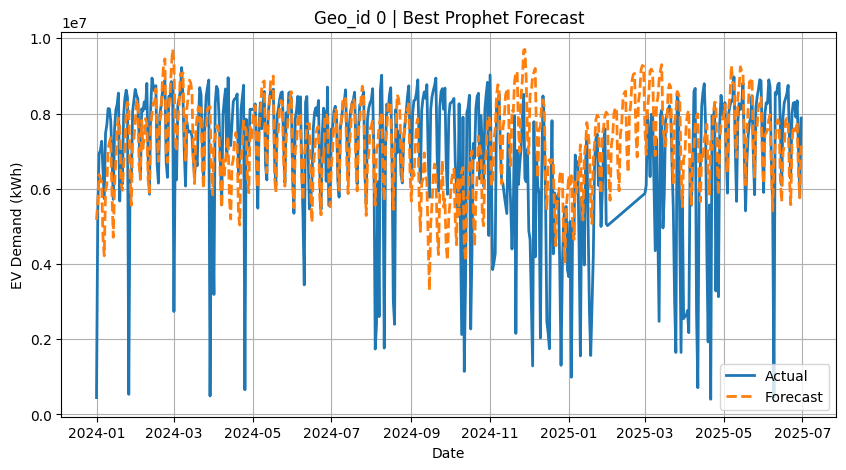

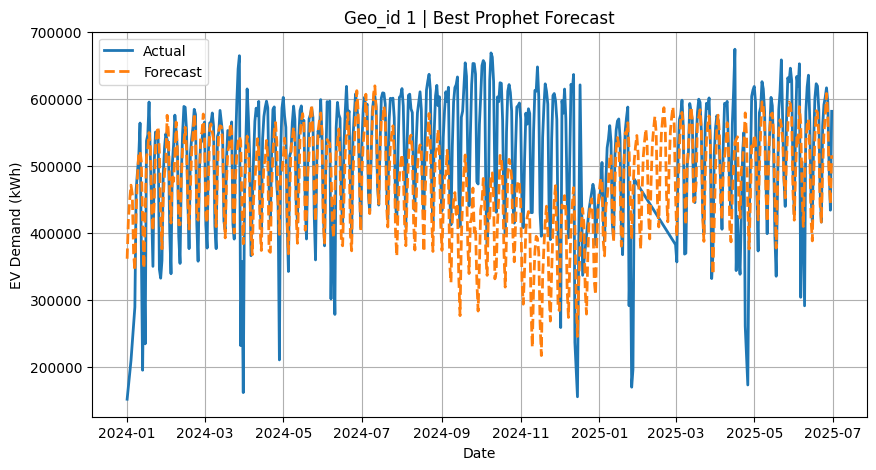

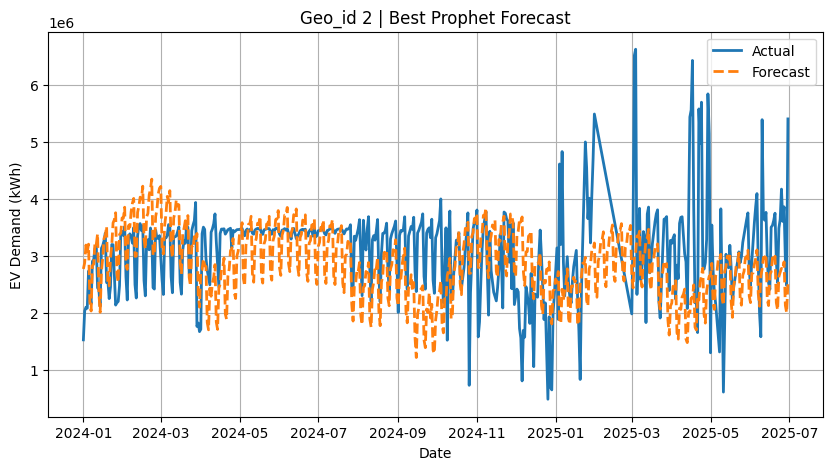

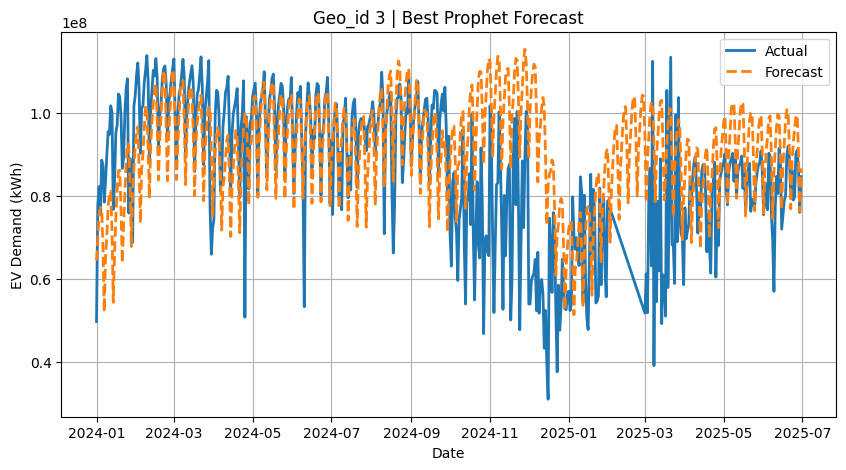

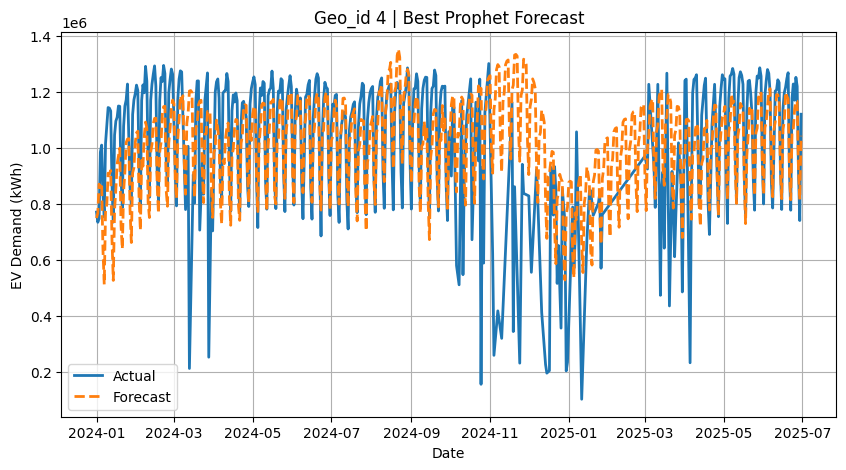

In [ ]:
for geo_id, res in Prophet_model.items():
    plt.figure(figsize=(10,5))
    plt.plot(res["y_test"]['ds'], res["y_test"]['y'], label="Actual", linewidth=2)
    plt.plot(res["y_pred"]['ds'], res["y_pred"]['yhat'], label="Forecast", linestyle="--", linewidth=2)
    plt.title(f"Geo_id {geo_id} | Best Prophet Forecast")
    plt.xlabel("Date")
    plt.ylabel("EV Demand (kWh)")
    plt.legend()
    plt.grid(True)
    plt.show()


**5. Build LSTM Model for EV Charging Demand Prediction**

In [ ]:
LSTM_result ={}

for i in geo_number:
  df = geo_clean[geo_clean['geo_cluster'] == i]
  df = df.drop(columns=['geo_cluster'])


  #Split the trainning and testing dataset
  training_set, test_set = time_split(df, start, end)

  #Save the train
  training_set_shape = training_set.shape
  test_set_shape = test_set.shape

  #Import the min_max scaller
  sc = MinMaxScaler(feature_range =(0,1))

  #Reshape training_set
  training_set = training_set.values.reshape(-1,1)
  training_set_scaled = sc.fit_transform(training_set)
  training_set_scaled = training_set_scaled.reshape(training_set_shape[0], test_set_shape[1])

  #Parameter prepare for the model
  n_steps = 50
  forecasting_horizon = 14
  features = 7
  y_index = 0

  #Split the X_train and y_train for model
  X_train, y_train = split_sequence(training_set_scaled, n_steps, forecasting_horizon, y_index)

  #Reshaping Y_train for model
  y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

  #Set the gru_model
  model_lstm = Sequential()
  model_lstm.add(LSTM(units=128, activation="tanh", input_shape=(n_steps, features)))
  model_lstm.add(Dropout(0.2))
  model_lstm.add(Dense(units=forecasting_horizon))
  model_lstm.compile(optimizer="RMSprop", loss="mse")

  #Set the early stop
  model_lstm.fit(X_train, y_train, epochs=200, batch_size=64)

  #Set the RNN testing
  input_values = test_set.values.reshape(-1,1)
  input_values = sc.transform(input_values)
  input_values = input_values.reshape(test_set_shape[0], test_set_shape[1])

  #Split the X_test and y_test
  X_test, y_test = split_sequence(input_values, n_steps, forecasting_horizon, y_index)

  #Predict the values
  predict_EV_demand = model_lstm.predict(X_test)
  predict_EV_demand = sc.inverse_transform(predict_EV_demand)

  #Inverst the testing values
  y_test = y_test.reshape(y_test.shape[0],y_test.shape[1])
  y_test = sc.inverse_transform(y_test)


  LSTM_result[i] = {
      "model" : model_lstm,
      "predict_EV_demand": predict_EV_demand,
      "y_test" : y_test,
  }



Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2515
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0606
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0546
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0546
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0506
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0507
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0442
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0449
Epoch 9/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0454
Epoch 10/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0420
Epoch 11/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0446
Epoch 12/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0431
Epoch 13/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0459
Epoch 14/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0412
Epoch 15/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0399
Epo

In [ ]:
best_LSTM_result = {}

for geo_id, res in LSTM_result.items():
    y_true = res["y_test"]
    y_pred = res["predict_EV_demand"]
    horizon = min(y_true.shape[1], y_pred.shape[1])

    # Initialize the best result for this geo_id
    best_for_geo = {
        "horizon": None,
        "mape": float("inf"),
        "mae": None,
        "rmse": None,
        "model": None,
        "y_test": None,
        "y_pred": None,
        "dates": None
    }

    print(f"\nGeo_id: {geo_id}")
    for i in range(horizon):
        mae, mape, rmse = return_metrics(y_true[:, i], y_pred[:, i])
        print(f"Horizon {i} | MAE={mae:.2f}, MAPE={mape:.2%}, RMSE={rmse:.2f}")

        # Update if MAPE is smaller than the current best for this geo_id
        if mape < best_for_geo["mape"]:
            best_for_geo = {
                "horizon": i,
                "mape": mape,
                "mae": mae,
                "rmse": rmse,
                "model": res["model"],
                "y_test": y_true[:, i],
                "y_pred": y_pred[:, i],
                "dates": res["y_test"]
            }

    # Save the best result for this geo_id
    best_LSTM_result[geo_id] = best_for_geo
    print("------------------")



Geo_id: 0
MAE: 1493382.30
MAPE: 45.30%
RMSE: 2029104.346027
Horizon 0 | MAE=1493382.30, MAPE=45.30%, RMSE=2029104.35
MAE: 1642702.47
MAPE: 50.80%
RMSE: 2240199.802518
Horizon 1 | MAE=1642702.47, MAPE=50.80%, RMSE=2240199.80
MAE: 1653714.11
MAPE: 47.35%
RMSE: 2157317.099157
Horizon 2 | MAE=1653714.11, MAPE=47.35%, RMSE=2157317.10
MAE: 1955496.65
MAPE: 45.08%
RMSE: 2337287.999915
Horizon 3 | MAE=1955496.65, MAPE=45.08%, RMSE=2337288.00
MAE: 2080453.29
MAPE: 45.37%
RMSE: 2406512.399766
Horizon 4 | MAE=2080453.29, MAPE=45.37%, RMSE=2406512.40
MAE: 1471463.15
MAPE: 44.36%
RMSE: 1980970.797695
Horizon 5 | MAE=1471463.15, MAPE=44.36%, RMSE=1980970.80
MAE: 1711602.61
MAPE: 54.50%
RMSE: 2332668.957743
Horizon 6 | MAE=1711602.61, MAPE=54.50%, RMSE=2332668.96
MAE: 1738923.87
MAPE: 54.07%
RMSE: 2342342.945111
Horizon 7 | MAE=1738923.87, MAPE=54.07%, RMSE=2342342.95
MAE: 2055092.51
MAPE: 62.99%
RMSE: 2686900.411239
Horizon 8 | MAE=2055092.51, MAPE=62.99%, RMSE=2686900.41
MAE: 1919249.27
MAPE: 61.8

In [ ]:
print('LSTM Model')
print('------------------')
for geo_id, res in best_LSTM_result.items():
    y_true = res['y_test']
    y_test = res['y_pred']
    mean_val = y_true.mean()

    print(f"Geo_id: {geo_id}")
    print(f"Horizon: {res['horizon']}")
    print(f"MAPE: {res['mape']:.2%}")
    print(f"MAE:  {res['mae']:.2f}")
    print(f"RMSE: {res['rmse']:.2f}")
    print("------------------")


LSTM Model
------------------
Geo_id: 0
Horizon: 5
MAPE: 44.36%
MAE:  1471463.15
RMSE: 1980970.80
------------------
Geo_id: 1
Horizon: 0
MAPE: 10.94%
MAE:  44856.28
RMSE: 63348.33
------------------
Geo_id: 2
Horizon: 0
MAPE: 21.74%
MAE:  517634.53
RMSE: 733860.60
------------------
Geo_id: 3
Horizon: 6
MAPE: 19.79%
MAE:  13807575.79
RMSE: 17747186.89
------------------
Geo_id: 4
Horizon: 0
MAPE: 23.01%
MAE:  151959.71
RMSE: 203663.50
------------------


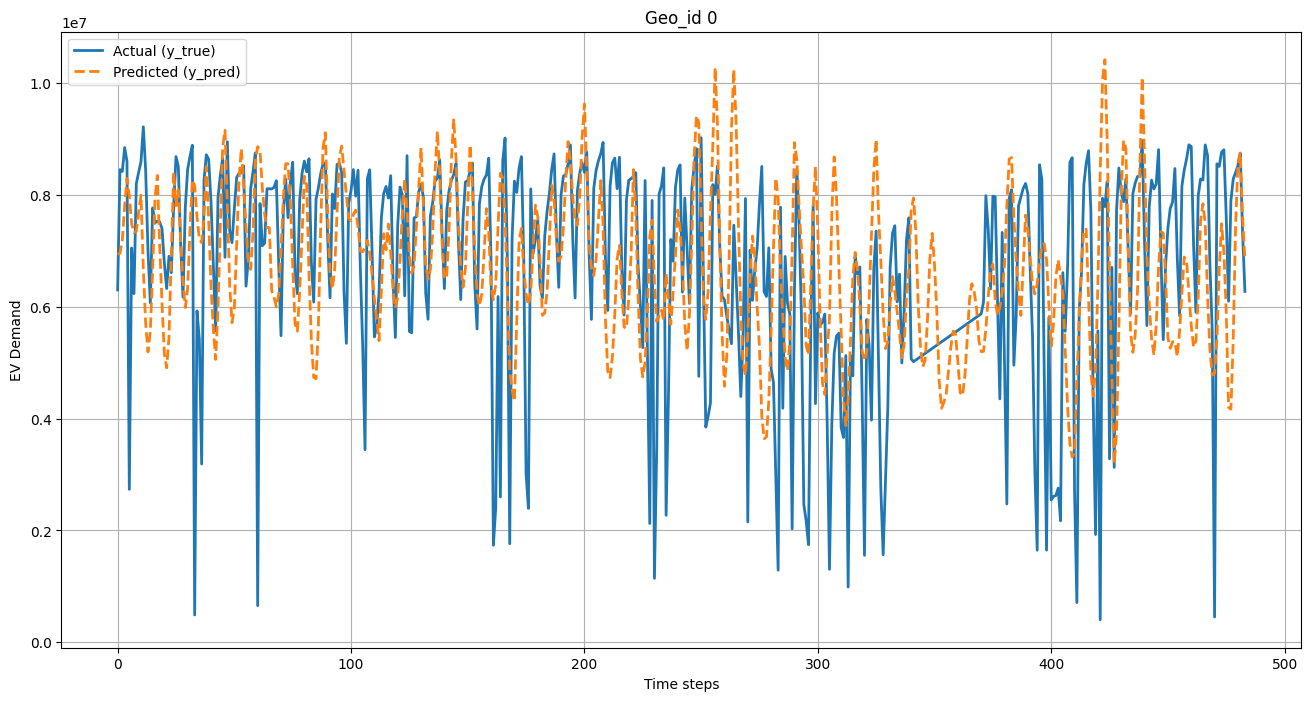

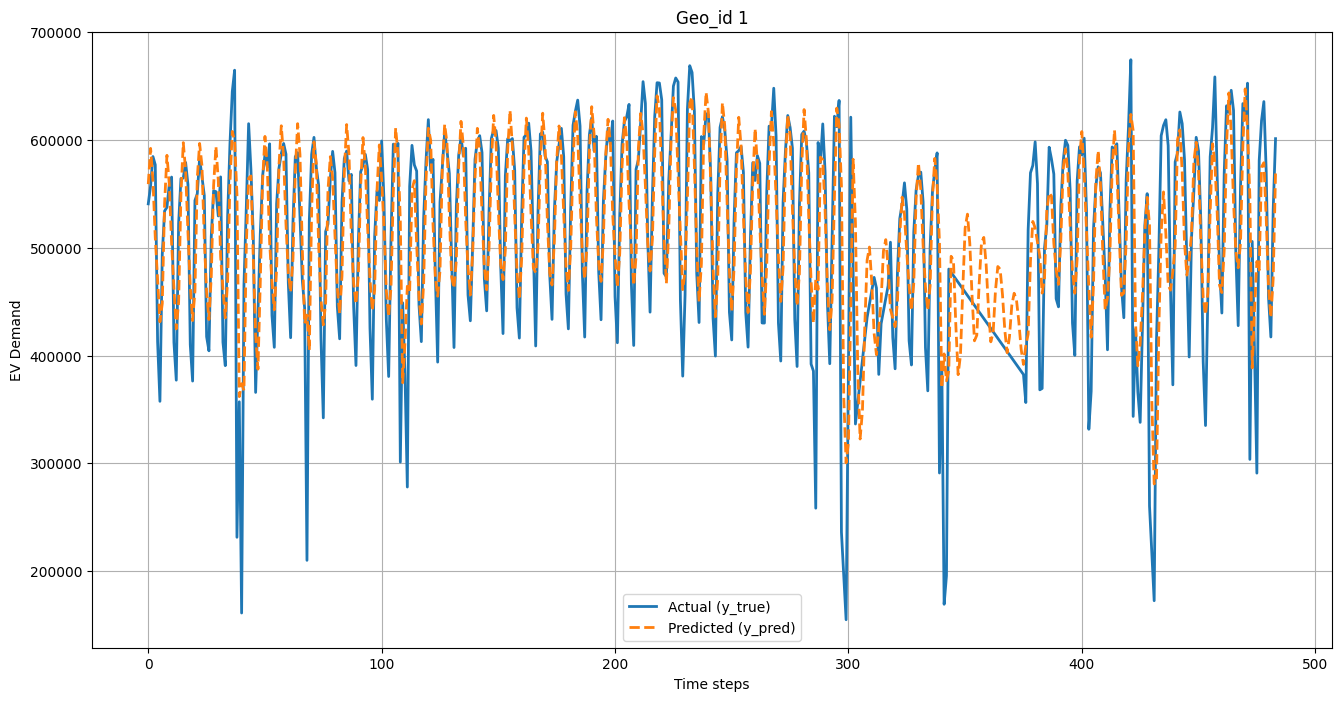

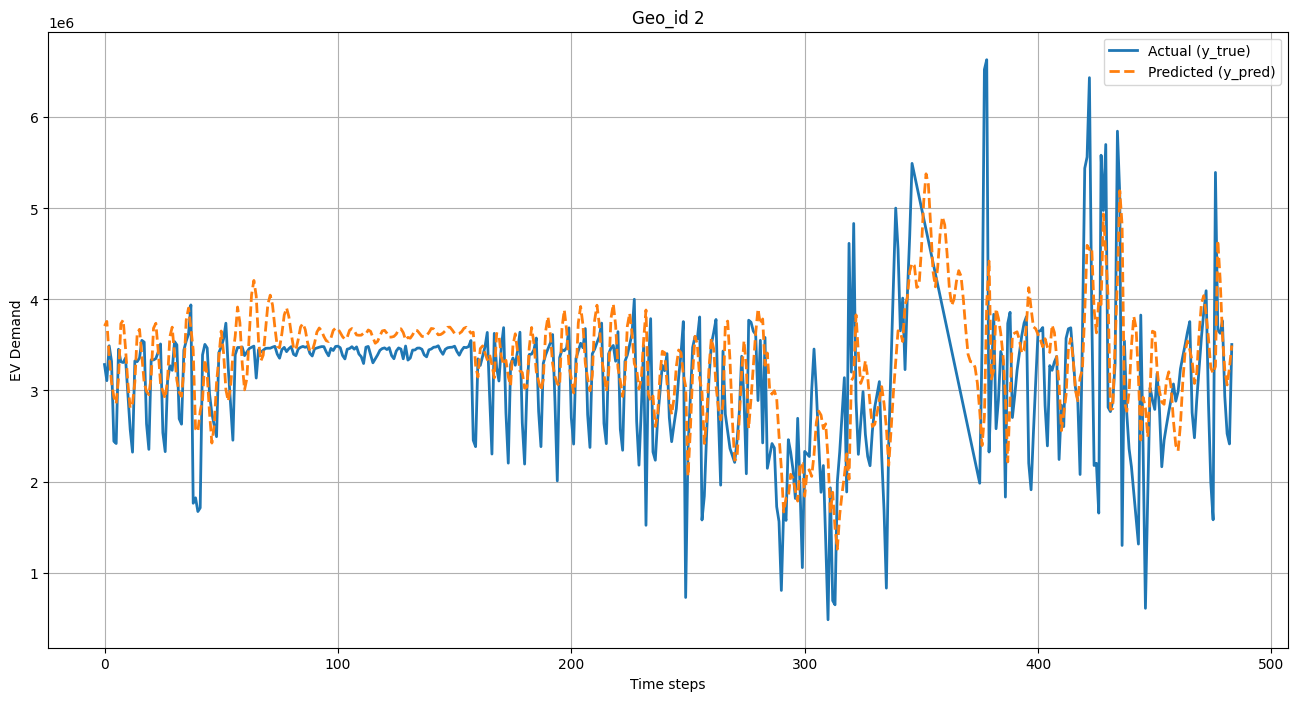

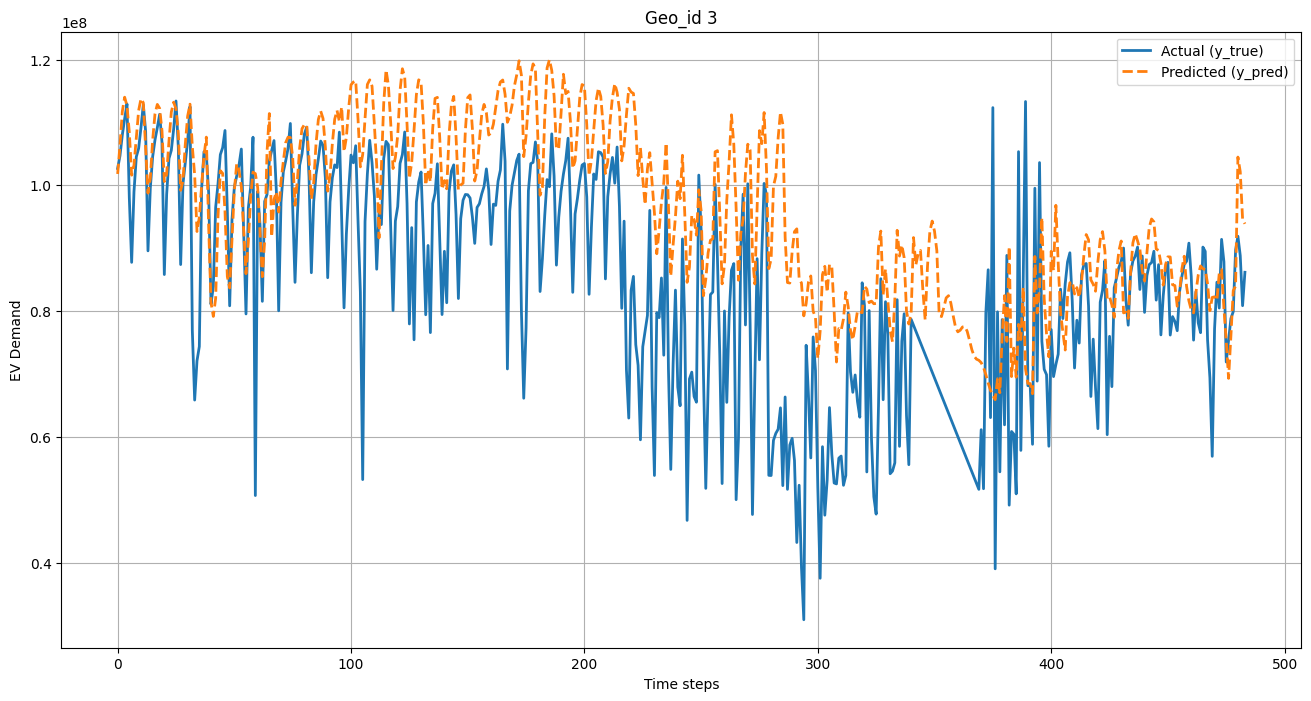

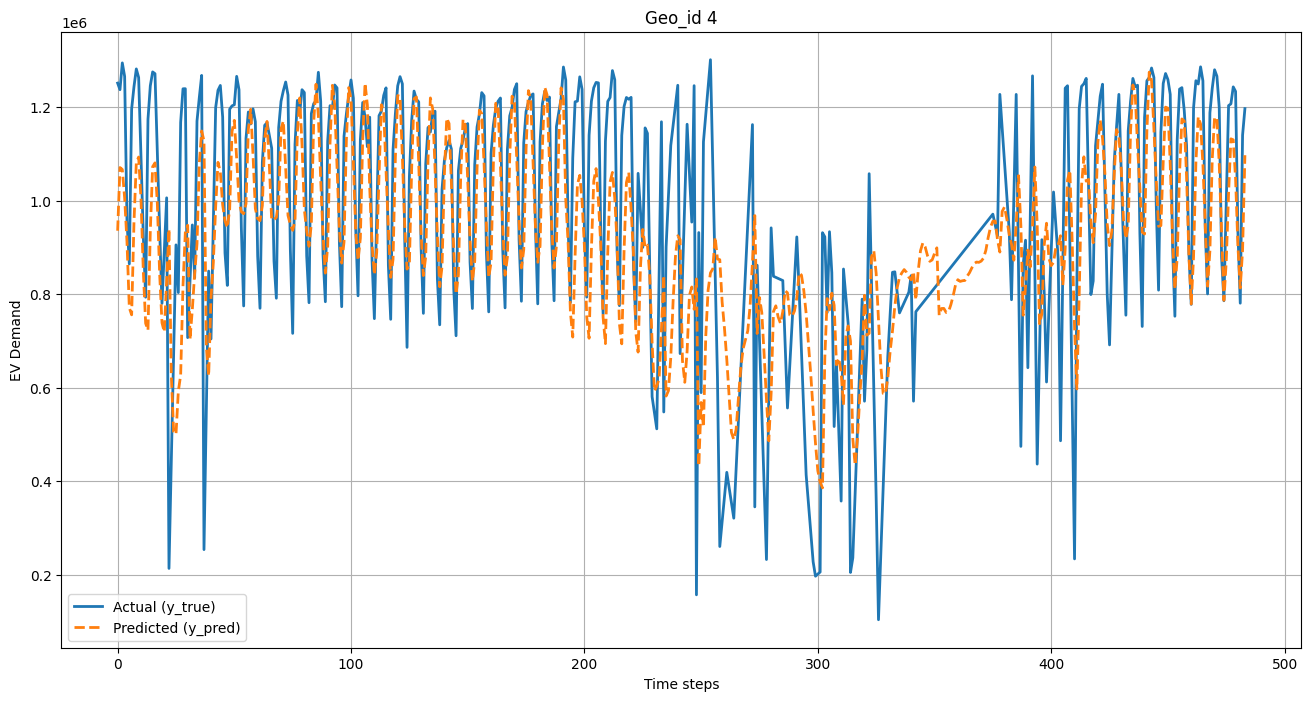

In [ ]:
for geo_id, res in best_LSTM_result.items():
    plt.figure(figsize=(16, 8))
    plt.plot(res["y_test"], label="Actual (y_true)", linewidth=2)
    plt.plot(res["y_pred"], label="Predicted (y_pred)", linewidth=2, linestyle="--")
    plt.title(f"Geo_id {geo_id}")
    plt.xlabel("Time steps")
    plt.ylabel("EV Demand")
    plt.legend()
    plt.grid(True)
    plt.show()

**6. Compare the model and choose the best model for deployt**

In [ ]:
# Print header row
print('Table 1: MAPE Result')
print(f"{'Geo_id':<7}{'LSTM':<12}{'Prophet':<15}{'SARIMA':<15}{'GRU':<12}")
print("-" * 65)

# Loop through Geo IDs
for geo_id in best_LSTM_result.keys():
    lstm_res = best_LSTM_result[geo_id]
    prop_res = Prophet_model[geo_id]
    sarima_res = SARIMA_model[geo_id]
    gru_res = best_GRU_result[geo_id]

    print(f"{geo_id:<7}"
          f"{lstm_res['mape']*100:<12.2f}"
          f"{prop_res['mape']*100:<15.2f}"
          f"{sarima_res['mape']*100:<15.2f}"
          f"{gru_res['mape']*100:<12.2f}")


Table 1: MAPE Result
Geo_id LSTM        Prophet        SARIMA         GRU         
-----------------------------------------------------------------
0      44.36       47.63          24.11          33.64       
1      10.94       16.80          59.83          10.95       
2      21.74       25.53          0.00           19.64       
3      19.79       19.25          0.79           10.68       
4      23.01       29.74          5.04           20.22       


In [ ]:
# Print header row
print('Table 2: MAE Result')
print(f"{'Geo_id':<7}{'LSTM':<12}{'Prophet':<15}{'SARIMA':<15}{'GRU':<12}")
print("-" * 65)

# Loop through Geo IDs
for geo_id in best_LSTM_result.keys():
    lstm_res = best_LSTM_result[geo_id]
    prop_res = Prophet_model[geo_id]
    sarima_res = SARIMA_model[geo_id]
    gru_res = best_GRU_result[geo_id]

    print(f"{geo_id:<7}"
          f"{lstm_res['mae']:<12.2f}"
          f"{prop_res['mae']:<15.2f}"
          f"{sarima_res['mae']:<15.2f}"
          f"{gru_res['mae']:<12.2f}")


Table 2: MAE Result
Geo_id LSTM        Prophet        SARIMA         GRU         
-----------------------------------------------------------------
0      1471463.15  1355605.42     1131152.18     1112763.89  
1      44856.28    72588.32       287552.62      46645.62    
2      517634.53   699336.52      0.00           463916.53   
3      13807575.79 13294380.05    451240.50      7827327.33  
4      151959.71   167703.43      30405.09       119043.16   


In [ ]:
# Print header row
print('Table 3: RMSE Result')
print(f"{'Geo_id':<7}{'LSTM':<12}{'Prophet':<15}{'SARIMA':<15}{'GRU':<12}")
print("-" * 65)

# Loop through Geo IDs
for geo_id in best_LSTM_result.keys():
    lstm_res = best_LSTM_result[geo_id]
    prop_res = Prophet_model[geo_id]
    sarima_res = SARIMA_model[geo_id]
    gru_res = best_GRU_result[geo_id]

    print(f"{geo_id:<7}"
          f"{lstm_res['rmse']:<12.2f}"
          f"{prop_res['rmse']:<15.2f}"
          f"{sarima_res['rmse']:<15.2f}"
          f"{gru_res['rmse']:<12.2f}")


Table 3: RMSE Result
Geo_id LSTM        Prophet        SARIMA         GRU         
-----------------------------------------------------------------
0      1980970.80  1991715.07     1301329.28     1575043.76  
1      63348.33    97412.44       288223.51      64670.87    
2      733860.60   939967.77      0.00           694468.74   
3      17747186.89 18103092.36    2741305.01     10747100.16 
4      203663.50   250695.93      45492.82       172953.10   


The performance tables indicate that SARIMA consistently achieves very low error values (MAPE, MAE, RMSE) across most Geo_ids, in some cases outperforming the neural models. However, this apparent strength is misleading because SARIMA’s results are highly sensitive to how anomalies were handled during preprocessing. Since anomalies were removed or replaced before fitting, the model is effectively being trained on an overly “clean” dataset. This cause overfitting of SARIMA on the datasets (seeing the figure in the building SARIMA section), which could reduce robustness for real-world forecasting where demand volatility and anomalies are unavoidable.

In contrast, the GRU model shows consistently strong and stable performance across all Geo_ids, with lower sensitivity to anomalies when comparing the other three models, including LSTM and Prophet. Although its error metrics are slightly higher than SARIMA's on paper, they are more reliable because the model was evaluated under realistic conditions. GRU captures temporal dependencies flexibly and generalises better, making it a safer choice for long-term deployment. Additionally, most of the GRU model's performance achieves less than 20% of MAPE, which indicates that this model is excellent in predicting models.